# Image Classification with Test-Time Adaptation Project

### Project Overview

In the field of computer vision, our team addresses one of the critical challenges in image classification: domain shift. While deep neural networks have made significant strides in visual recognition tasks, they often struggle when confronted with real-world scenarios that deviate from their training data. To investigate this phenomenon, we will utilize the ImageNet-A dataset, which presents a particularly challenging set of images across a wide variety of classes.

Our project aims to mitigate this performance gap by focusing on Test-Time Adaptation (TTA). We will implement and evaluate two primary methods using a CLIP ViT-B/32 model as our foundation:

1. Marginal Entropy Minimization with One test point (MEMO)
2. Contrastive Prompt Tuning (CoOp) with Test-time Prompt Tuning (TPT)

Additionally, we will introduce a novel approach that we have termed "Entropy Boosting". Furthermore, we will explore the integration of monocular depth estimation, utilizing the Depth Anything model, into our image classification pipeline to enhance performance.

### The Team

This project is conducted under the supervision of Dr. Elisa Ricci and Dr. Francesco Tonini. Our team comprises:

- Pietro Begotti (Matricola: ?)
- Javier Montané Ortuño (Matricola: 245729)
- Christian Dalvit (Matricola: ?)

## Imports

In [3]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install datasets transformers
! pip install seaborn
import clip
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import copy
import numpy as np


#Used for testing:
import boto3
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from dataclasses import dataclass, asdict
from typing import List, Dict
import os
import json
from torch.utils.data import Subset
import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor, to_pil_image


#Used for visualizing results
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ipywidgets import widgets, interactive_output, Dropdown, Output, VBox, Button
from IPython.display import display  




  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6squavgf
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6squavgf
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
#For Depth Estimation
%cd /home/sagemaker-user/ImageClassificationAssignment
!git clone https://github.com/LiheYoung/Depth-Anything
!sudo apt-get install -y libgl1-mesa-glx
!pip install opencv-python-headless
%cd /home/sagemaker-user/ImageClassificationAssignment/Depth-Anything
!pip install -r requirements.txt
import cv2
# Import from depth_anything package
from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet
%cd /home/sagemaker-user/ImageClassificationAssignment

## Useful functions

- **`cos_sim(self, image_features, text_features)`**
  - Calculates the cosine similarity between image and text features.
- **`logits(self, image_features, text_features)`**
  - Computes the logits by applying a scale factor (temperature already learned by CLIP) to the cosine similarities.
- **`class_probabilities(self, image_features, text_features)`**
  - Converts logits to class probabilities using the softmax function.

In [2]:
def load_cifar100():
    cifar100 = torchvision.datasets.CIFAR100(root='./data', download=True, train=False)
    return cifar100

def cos_sim(image_features, text_features):
    return  image_features @ text_features.T

def compute_logits(image_features, text_features, logit_scale):
    logit_scale = logit_scale.exp()
    return logit_scale * cos_sim(image_features, text_features)

def class_probabilities(image_features, text_features, logit_scale):
    return  compute_logits(image_features, text_features, logit_scale).softmax(dim=-1)

def marginal_entropy(logits):
    z = logits - logits.logsumexp(dim = -1, keepdim=True)     # compute z_ij
    marginal_logp = z.logsumexp(dim=0) - np.log(z.shape[0])   # compute marginal log probabilities

    min_real = torch.finfo(marginal_logp.dtype).min           # for numerical stability, the smallest representable number given the dtype of logits.
    avg_logits = torch.clamp(marginal_logp, min = min_real)   # put a threshold to avoid underflow

    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)

def shanon_entropy(x): #Shanon entropy in bits
    log_x = torch.log2(x.clamp_min(1e-20))
    entropy = -torch.sum(x * log_x)
    return entropy

## CLIP


#### Constructor
- **`__init__(self, model_name='ViT-B/32', device=None)`**
  - Initializes the model with a specified model name and device. Defaults to using CUDA if available. It sets up the optimizer and default parameters for the model. And casts it to float 32 to use ADAM. Also sets a `changeseed` to be able to have different random generations in a loop for Entropy Boosting.

#### Optimizer Methods
- **`use_ADAM(self)`**
  - Changes the optimizer of the model to ADAM.
- **`use_SGD(self)`**
  - Switches the optimizer to SGD.
- **`convert_model_parameters_to_float32(self, model)`**
    - This is for ADAM to work. Converts all model parameters to float32 data type.
- **`grad_descent_step(self, loss)`**
    - Performs a single gradient descent step using the computed loss, updating the model parameters accordingly. This is what modifies the clip model stored in the object.

#### Gradient Handling
- **`require_CLIP_gradients(self, state=True)`**
  - Enables or disables the calculation of gradients for model parameters based on the specified state.

#### Data Handling
- **`load_data(self)`**
  - This is just to have some data easy to access to test the methods on some image. Loads the CIFAR100 dataset which is useful for testing or validating the model performance on image data.
 
#### Tokenization of labels
- **`tokenize_labels(self, classes)`**
    - Converts a list of class labels into text tokens using CLIP's tokenizer and encodes them into text features. This is used for matching text descriptions with images. For now this is just used with a photo of a {class} and then stored as an attribute so that we can reuse it for every method.
 
#### Predictions with the CLIP model out of the box
- **`forward(self, image)`**
    - Processes an image through the model, encoding it into image features, normalizing these features, and then computing the class probabilities.
- **`predict(self, image)`**
    - Completes the prediction process including preprocessing the image, computing probabilities, and determining the most probable class along with its entropy. This is what you can use to compute CLIP out of the box predictions.

In [3]:
class CLIP:

    def __init__(self, model_name='ViT-B/32', device=None):
        self.device = device if device else "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load(model_name, self.device)
        self.model = self.convert_model_parameters_to_float32(self.model)
        self.optimizer = optim.SGD(self.model.parameters(), lr=1e-5, momentum=0.9)
        self.text_features = None
        self.requiring_grads = None
        self.scale = self.model.logit_scale #temperature parameter learned by CLIP
        self.changeseed = 0 #This is to be able to do diverse random transforms but replicable

    def use_ADAM(self):
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-5)

    def use_SGD(self):
        self.optimizer = optim.SGD(self.model.parameters(), lr=1e-5, momentum=0.9)

    def require_CLIP_gradients(self, state = True):
        if self.requiring_grads is None or state != self.requiring_grads: #don't change if the state is already OK
            for param in self.model.parameters():
                param.requires_grad = state
            self.requiring_grads = state

    def convert_model_parameters_to_float32(self, model):
        for param in model.parameters():
            param.data = param.data.to(torch.float32)
        return model

    def tokenize_labels(self, classes): #We use heuristic labels
        text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(self.device)
        with torch.no_grad():
            self.text_features = self.model.encode_text(text_inputs)
            self.text_features /= self.text_features.norm(dim=-1, p=2, keepdim=True)

    def grad_descent_step(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def forward(self, image):
        image_features = self.model.encode_image(image)
        norms = image_features.norm(dim=-1, p=2,  keepdim=True)
        if (norms == 0).any():
            print("Zero norm found in image features")
        image_features = image_features / norms.clamp_min(1e-10)
        return class_probabilities(image_features, self.text_features, self.scale)

    def predict(self, image):
        self.model.eval()
        image = self.preprocess(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            probs = self.forward(image)

        prediction = torch.argmax(probs).item()
        entropy = float(shanon_entropy(probs))
        return prediction, probs.squeeze(), entropy


# Instantiate a CLIP object
clip_model = CLIP()

## MEMO


#### Transformations
- **`augment_image(self, image, num_augmentations=100, transformations=None)`**
  - Applies specified transformations to an image (or a random transformation if none given) to generate multiple augmented versions.
  - This method is the exact same for both MEMO and TPT




- **`entropy_loss_MEMO(self, batch_features, text_features=None)`**
  - Calculates the entropy loss for the MEMO strategy using marginal entropy.



#### Methods used to get predictions
- **`MEMO(self, image, num_augmentations=100)`**
  - Implements MEMO strategy by optimizing model parameters to minimize entropy across predictions.



In [4]:
class MEMO:

    def __init__(self, CLIP):
        self.clip = CLIP

    def augment_image(self, image, num_augmentations=100, transformations=None):
        if transformations==None:
            torch.manual_seed(33)#Set a seed for reproducibility of the random augmentations
            augmentations = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(degrees=30),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            ])
        augmented_images = [self.clip.preprocess(image).unsqueeze(0).to(self.clip.device)] #Add the original image to the batch of augmentations
        for _ in range(num_augmentations):
            augmented_images.append(self.clip.preprocess(augmentations(image)).unsqueeze(0).to(self.clip.device))
        batch = torch.vstack(augmented_images)
        return batch #(num_augumentations + 1, 3, 224, 224)

    def entropy_loss_MEMO(self, batch_features, text_features = None):
        if text_features is None:
            text_features = self.clip.text_features
        #Logits (unnormalized probabilities)
        logits = compute_logits(batch_features, text_features, self.clip.scale)
        # Compute the entropy of every text caption accross all augmentations
        return marginal_entropy(logits)

    def MEMO(self, image, num_augmentations=100):
        # Save original parameters
        original_params = {name: param.clone() for name, param in self.clip.model.named_parameters()}

        # Require gradients to update the CLIP parameters
        self.clip.require_CLIP_gradients(state = True)

        try:
            self.clip.model.train()
            batch = self.augment_image(image, num_augmentations)
            batch_features = self.clip.model.encode_image(batch)
            norms = batch_features.norm(dim=-1, p=2, keepdim=True)
            if (norms == 0).any():
                print("Zero norm found in image features")
            batch_features = batch_features / norms.clamp_min(1e-10)
            loss = self.entropy_loss_MEMO(batch_features)
            self.clip.grad_descent_step(loss)

            if any(torch.isnan(param).any() for param in self.clip.model.parameters()):
                print("nan values detected in model parameters after updating")
            # Predict using the updated model
            prediction, probs, entropy = self.clip.predict(image)
        finally:
            # Restore original parameters
            with torch.no_grad():
                for name, param in self.clip.model.named_parameters():
                    param.copy_(original_params[name])
        return prediction, probs.squeeze(), entropy



# Instantiate a MEMO object
memo = MEMO(clip_model)

## CoOp + TPT

### Coop

We have downloaded the pretrained weights (on ImageNet) from https://drive.google.com/file/d/18ypxfd82RR0pizc5MM1ZWDYDk4j0BtPF/view

Since we are using CLIP ViT-B/32, have 2 options: 4 or 16 context tokens. According to the Table 1 from the original CoOp paper, CoOp with M=4 performed slightly better (the differences are in the order of 1% so are probably not very significant) in Imagenet-V2 and Imagenet-A so we will be using them. Also notice that these weights were pretrained on ImageNet for 50 epocs.

Even now, there are 3 seeds to choose from. We will take the 2nd seed because it is the one that got the lowest error on the test set after the training (this can be checked in the log.txt file that come with the weights zip). Again, this discrepancy is of 0.1% and 0.2% with the other seeds, so it is negligible.

In [6]:
# Example usage
model_path = 'CoOp Weights/model.pth.tar'
coop = CoOpModel(model_name='ViT-B/32', weight_path=model_path)

In [67]:
!pwd

/home/sagemaker-user/ImageClassificationAssignment


In [8]:
import torch

def inspect_checkpoint(checkpoint_path):
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    
    # Check if it is a simple state dictionary or a more complex dictionary
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint
    
    # Print the keys in the state dictionary
    print("Keys in the checkpoint state dictionary:")
    for key in state_dict.keys():
        print(key)
    
    # Optionally, display more detailed information about each parameter
    print("\nDetailed information about each parameter:")
    for key, value in state_dict.items():
        print(f"{key}:")
        print(f"  Tensor Shape: {value.shape}")
        print(f"  Tensor Mean: {value.mean()}")
        print(f"  Tensor Std: {value.std()}\n")

# Usage
checkpoint_path = 'CoOp Weights/model.pth.tar'  # Replace with your actual checkpoint path
inspect_checkpoint(checkpoint_path)


Keys in the checkpoint state dictionary:
ctx
token_prefix
token_suffix

Detailed information about each parameter:
ctx:
  Tensor Shape: torch.Size([4, 512])
  Tensor Mean: 0.0005750656127929688
  Tensor Std: 0.07916259765625

token_prefix:
  Tensor Shape: torch.Size([1000, 1, 512])
  Tensor Mean: 0.0
  Tensor Std: 0.0174407958984375

token_suffix:
  Tensor Shape: torch.Size([1000, 72, 512])
  Tensor Mean: 0.0
  Tensor Std: 0.01395416259765625



#### Our CoOp Implementation

In [1]:
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer

_tokenizer = _Tokenizer()

class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        # Initialize the TextEncoder with components from the CLIP model
        self.transformer = clip_model.transformer  # CLIP's transformer for text processing
        self.positional_embedding = clip_model.positional_embedding  # Positional embeddings for input tokens
        self.ln_final = clip_model.ln_final  # Final layer normalization
        self.text_projection = clip_model.text_projection  # Projection layer for text features

    def forward(self, prompts, tokenized_prompts):
        # prompts: tensor of shape [batch_size, n_ctx, transformer.width]
        # tokenized_prompts: tensor of shape [batch_size, 77] (CLIP uses 77 tokens max)
        
        # Add positional embeddings to the input prompts
        x = prompts + self.positional_embedding
        
        # Permute dimensions for transformer input
        # [batch_size, n_ctx, transformer.width] -> [n_ctx, batch_size, transformer.width]
        x = x.permute(1, 0, 2)
        
        # Pass through the text transformer (getting the text features)
        x = self.transformer(x)
        
        # Permute dimensions back
        # [n_ctx, batch_size, transformer.width] -> [batch_size, n_ctx, transformer.width]
        x = x.permute(1, 0, 2)
        
        # Apply final layer normalization
        x = self.ln_final(x)

        # Extract features from the end-of-text (eot) embedding for each sequence in the batch and then projecting these features using self.text_projection with a matrix multiplication
        # eot_token is assumed to be the highest number in each sequence
        # torch.arange(x.shape[0]) represents the batch indices
        # tokenized_prompts.argmax(dim=-1) finds the position of the eot token
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection 
        
        # Return the final text features
        return x

class PromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, class_token_position, csc=False, path_to_chekpt='CoOp Weights/model.pth.tar'):
        super().__init__()
        n_cls = len(classnames)

        # Load the ctx_vector
        ctx_vector = load_ctx_from_checkpoint(path_to_chekpt, clip_model.token_embedding.weight.device) # torch.Size([4, 512]) [n_ctx=4, ctx_dim=512]
        n_ctx = ctx_vector.size(0)
        if clip_model.ln_final.weight.shape[0] != ctx_vector.size(1):
            raise KeyError("Context Dimension of the clip model does not match the one of the checkpoint.")

        if csc:
            # Add the n_cls dimension to the ctx_vector of size: [n_cls, n_ctx, ctx_dim]
            print("Initializing class-specific contexts")
            ctx_vector = ctx_vector.unsqueeze(0).expand(n_cls, -1, -1)
        else:
            # No need to add the n_cls dimension to the ctx_vector
            print("Initializing a generic context")
        # ctx is the learnable parameter in the prompt
        self.ctx = nn.Parameter(ctx_vector)


        # Process class names
        classnames = [name.replace("_", " ") for name in classnames]
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompt_prefix = " ".join(["X"] * n_ctx)
        prompts = [prompt_prefix + " " + name + "." for name in classnames] # Here we use the prompt_prefix but we will only keep the tokens of the SOS, the class and EOS

        # Tokenize prompts
        tokenized_prompts = torch.cat([clip.tokenize(p) for p in prompts]).to(clip_model.token_embedding.weight.device)

        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts)

        # Store the non-learnable tokens
        # token_prefix is the start-of-sentence token
        # token_suffix includes the class name and end-of-sentence tokens
        # register_buffer is a method in PyTorch's nn.Module class that registers a tensor as a buffer.
        # Buffers are tensors that are not considered parameters, but are part of the module's state.
        # They are not updated by the optimizer but are saved and restored in the module's state_dict.
        self.register_buffer("token_prefix", embedding[:, :1, :])  #! This is where pretrained weights for token_prefix could be set for inference
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  #! This is where pretrained weights for token_suffix could be set for inference

        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.tokenized_prompts = tokenized_prompts  # Numerical token representations of the string, not the learnable parameters
        self.name_lens = name_lens # length of each classname token
        self.class_token_position = class_token_position #This is an input, can be set to "front", "mid" or "back". Is where the class tokens are placed

    def load_ctx_from_checkpoint(self, checkpoint_path, device):
        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=torch.device(device))
        
        # Check if it is a simple state dictionary or a more complex dictionary
        if 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint
        
        # Extract the ctx tensor
        if 'ctx' in state_dict:
            ctx_tensor = state_dict['ctx']
            return ctx_tensor
        else:
            raise KeyError("The 'ctx' tensor was not found in the checkpoint.")


    def forward(self):
        # Construct the full prompt embeddings
        prefix = self.token_prefix  # Start-of-sentence token
        suffix = self.token_suffix  # Class name and end-of-sentence tokens
        ctx = self.ctx  # Learnable context

        # For CoOp (non-CSC), expand ctx for all classes
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)

        # Combine prefix, context, and suffix based on class_token_position
        if self.class_token_position == "end":
            prompts = torch.cat(
                [
                    prefix,  # (n_cls, 1, dim)
                    ctx,     # (n_cls, n_ctx, dim)
                    suffix,  # (n_cls, *, dim)
                ],
                dim=1,
            )
        elif self.class_token_position == "middle":
            # Insert class token in the middle of the context
            half_n_ctx = self.n_ctx // 2
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i_half1 = ctx[i : i + 1, :half_n_ctx, :]
                ctx_i_half2 = ctx[i : i + 1, half_n_ctx:, :]
                prompt = torch.cat(
                    [
                        prefix_i,     # (1, 1, dim)
                        ctx_i_half1,  # (1, n_ctx//2, dim)
                        class_i,      # (1, name_len, dim)
                        ctx_i_half2,  # (1, n_ctx//2, dim)
                        suffix_i,     # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        elif self.class_token_position == "front":
            # Insert class token at the beginning of the context
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i : i + 1, :, :]
                class_i = suffix[i : i + 1, :name_len, :]
                suffix_i = suffix[i : i + 1, name_len:, :]
                ctx_i = ctx[i : i + 1, :, :]
                prompt = torch.cat(
                    [
                        prefix_i,  # (1, 1, dim)
                        class_i,   # (1, name_len, dim)
                        ctx_i,     # (1, n_ctx, dim)
                        suffix_i,  # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        else:
            raise ValueError

        return prompts  # Returns the full prompt embeddings

class CLIPCoOp(nn.Module):
    def __init__(self, CLIP, classnames, class_token_position, csc=False):
        super().__init__()
        clip_model = CLIP.model
        #clip_model = clip_model.float()

        self.prompt_learner = PromptLearner(clip_model, classnames, class_token_position, csc=False)
        self.tokenized_prompts = self.prompt_learner.tokenized_prompts  # Numerical token representations
        self.image_encoder = clip_model.visual
        self.text_encoder = TextEncoder(clip_model)
        self.logit_scale = clip_model.logit_scale

    def forward(self, image):
        image_features = self.image_encoder(image)

        prompts = self.prompt_learner.forward()  # Get full prompt embeddings 
        tokenized_prompts = self.tokenized_prompts  # Numerical token representations of the string, not the learnable parameters
        text_features = self.text_encoder.forward(prompts, tokenized_prompts) 

        # Normalize features
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Compute logits
        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits

In [ ]:
CLIPCoOp(clip_model, classnames, class_token_position, csc=False)

In [ ]:
def get_optimizer(model, lr, wd, momentum):
    optimizer = torch.optim.SGD([
        {"params": model.parameters()}
    ], lr=lr, weight_decay=wd, momentum=momentum)

    return optimizer

def main_coop(
    dataset_name="cifar10",
    batch_size=16,
    num_classes=10,
    device="cuda:0",
    learning_rate=0.002,
    weight_decay=0.0005,
    momentum=0.9,
    epochs=2,
    run_name="exp1",
    n_ctx=4,
    ctx_init="",
    class_token_position="end",
    csc=False,
):
    # Create a logger for the experiment
    writer = SummaryWriter(log_dir=f"runs/{run_name}")

    # Get dataloaders
    train_loader, val_loader, test_loader = get_data(dataset_name, transform=preprocess, batch_size=batch_size)
    classnames, _ = embed_dataset_classnames(dataset_name)

    # Instantiate the network and move it to the chosen device (GPU)
    net = OurCLIP(
        classnames=classnames, n_ctx=n_ctx, ctx_init=ctx_init, class_token_position=class_token_position, csc=csc
    ).to(device)

    print("Turning off gradients in both the image and the text encoder")
    for name, param in net.named_parameters():
        if "prompt_learner" not in name:
            param.requires_grad_(False)

    print(f"Total parameters: {sum(p.numel() for p in net.parameters()):,}")
    print(f"Total trainable parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad):,}")

    # Instantiate the optimizer
    optimizer = get_optimizer(net, learning_rate, weight_decay, momentum)

    # Define the cost function
    cost_function = get_cost_function()

    # Computes evaluation results before training
    print("Before training:")
    train_loss, train_accuracy = test_step(net, train_loader, cost_function)
    val_loss, val_accuracy = test_step(net, val_loader, cost_function)
    test_loss, test_accuracy = test_step(net, test_loader, cost_function)

    # Log to TensorBoard
    log_values(writer, -1, train_loss, train_accuracy, "train")
    log_values(writer, -1, val_loss, val_accuracy, "validation")
    log_values(writer, -1, test_loss, test_accuracy, "test")

    print(f"\tTraining loss {train_loss:.5f}, Training accuracy {train_accuracy:.2f}")
    print(f"\tValidation loss {val_loss:.5f}, Validation accuracy {val_accuracy:.2f}")
    print(f"\tTest loss {test_loss:.5f}, Test accuracy {test_accuracy:.2f}")

    # For each epoch, train the network and then compute evaluation results
    for e in range(epochs):
        train_loss, train_accuracy = training_step(net, train_loader, optimizer, cost_function)
        val_loss, val_accuracy = test_step(net, val_loader, cost_function)

        log_values(writer, e, train_loss, train_accuracy, "train")
        log_values(writer, e, val_loss, val_accuracy, "validation")

    # Compute final evaluation results
    print("After training:")
    train_loss, train_accuracy = test_step(net, train_loader, cost_function)
    val_loss, val_accuracy = test_step(net, val_loader, cost_function)
    test_loss, test_accuracy = test_step(net, test_loader, cost_function)

    log_values(writer, epochs, train_loss, train_accuracy, "train")
    log_values(writer, epochs, val_loss, val_accuracy, "validation")
    log_values(writer, epochs, test_loss, test_accuracy, "test")
    print(f"\tTraining loss {train_loss:.5f}, Training accuracy {train_accuracy:.2f}")
    print(f"\tValidation loss {val_loss:.5f}, Validation accuracy {val_accuracy:.2f}")
    print(f"\tTest loss {test_loss:.5f}, Test accuracy {test_accuracy:.2f}")

    # Closes the logger
    writer.close()

### Test-Time Prompt Tuning (TPT) for Image Classification with CLIP

Test-Time Prompt Tuning (TPT) is a method designed to enhance the performance of vision-language models like CLIP by adapting the text prompts dynamically at test time. This approach is particularly useful in zero-shot learning scenarios where the model needs to generalize to new tasks without additional training.

#### Concept Overview

TPT optimizes the text prompt to improve consistency and confidence in the model's predictions across various augmented views of a test image. By minimizing the entropy of the prediction distribution average across low-entropy augmentations, TPT attempts to make the model more reliable and robust, even under slight variations in input data.

#### Implementation Details

##### Step 1: Initial Setup
- **Model Preparation**: Instantiate the pre-trained `CLIP ViT-B/32` model.
- **Prompt Initialization**: Start with a basic prompt template like "a photo of a {object}", processed using the `tokenize_labels` method.

##### Step 2: Augmentation and Prediction
- **Generate Augmented Views**: Create multiple augmented versions of the test image using the `augment_image` method, which might include crops, rotations, and color adjustments, etc.

##### Step 3: Define the Optimization Objective
The goal is to minimize the entropy of the predicted probability distribution across different classes for the test image, computed using the `entropy_loss_TPT` method.

##### Equation for Entropy Minimization:
\\[ p^* = \arg\min_p -\sum_{i=1}^K \tilde{p}_p(y_i | X_{\text{test}}) \log \tilde{p}_p(y_i | X_{\text{test}}) \\]
Where:
- \\( p^* \\) is the optimized prompt.
- \\( K \\) is the number of classes.
- \\( \tilde{p}_p(y_i | X_{\text{test}}) \\) is the averaged predicted probability for class \( y_i \) also returned in `entropy_loss_TPT`.

With the Averaged Prediction Probability defined as:
\\[ \tilde{p}_p(y_i | X_{\text{test}}) = \frac{1}{N} \sum_{n=1}^N p_p(y_i | A_i(X_{\text{test}})) \\]
- \\( N \\) is the number of augmented views.
- \\( A_i(X_{\text{test}}) \\) denotes the \( i \)-th augmented view of the test image.

##### Step 4: Optimize the Prompt
In the paper, they use gradient-based optimization to adjust the prompt parameters (provided by CoOp or CoCoOp) by minimizing the entropy. In our case, we decided that training CoOp or CoCoOp is not what we want to focus on for the project, therefor, for now what `TPT` method gives us is a evaluation of how good the prompts are that we will use to guide a wider classification method.

##### Step 5: Confidence Selection
Filter out noisy predictions by applying a confidence selection mechanism (`confidence_selection`) that discards the augmentations with the highest entropy (over a threshold value).

##### Confidence-Based Averaging:
\\[ \tilde{p}_p(y | X_{\text{test}}) = \frac{1}{\rho N} \sum_{i=1}^N 1[H(p_i) \leq \tau] p_p(y | A_i(X_{\text{test}})) \\]
- \\(\rho\\) is the cutoff percentile on the N augmented views (set to 0.8 by default in our implementation).
- \\( [H(p_i) \leq \tau] \\) is an indicator function that filters predictions based on their entropy \\( H \\), with \\( \tau \\) being a threshold set in the `confidence_selection` method as the entropy of the \\(\rho\\) percentile. We are removing the augmentations with the highest entropy in the top 20%.


##### Step 6: Final Prediction
Apply the optimized prompt to make the final prediction on the original test image using the `TPT` method, which performs the entire sequence described above except for the prompt optimization which we will implement in other method without using CoOp or CoCoOp.

#### Note:
Apart from what the paper says, I TPT alone without prompt optimization returns the averaged probability over low-entropy augmentations without doing any training. This is basically saying that all the top 80% lowest entropy augmentations are equally valid and averages the predictions across them, so the original image does not have more weight in the output than the augmentations. This is not the use proposed bythe paper but I am runing it as well to see how it does. I mean, the idea is not that crazy actually, although it is quite sensitive to the kind of augmentations we do (if we have bad augmentations in the low entropy 80%, we will be saying that those are equally valid).

In [5]:
class TPT:

    def __init__(self, CLIP):
        self.clip = CLIP

    def augment_image(self, image, num_augmentations=100, transformations=None):
        if transformations==None:
            torch.manual_seed(33)#Set a seed for reproducibility of the random augmentations
            augmentations = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(degrees=30),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            ])
        augmented_images = [self.clip.preprocess(image).unsqueeze(0).to(self.clip.device)] #Add the original image to the batch of augmentations
        for _ in range(num_augmentations):
            augmented_images.append(self.clip.preprocess(augmentations(image)).unsqueeze(0).to(self.clip.device))
        batch = torch.vstack(augmented_images)
        return batch #(num_augumentations + 1, 3, 224, 224)

    def confidence_selection(self, probs_matrix, percentile=0.8):
        # Compute entropies for each row in the probability matrix
        entropies = torch.tensor([shanon_entropy(row) for row in probs_matrix])

        # Find the threshold for the desired percentile
        threshold = torch.quantile(entropies, percentile, interpolation = 'linear')

        # Create a boolean mask where entropies below the threshold are selected
        boolean_mask = entropies < threshold

        # Assuming similarities is intended to be probs_matrix, return filtered matrix
        return probs_matrix[boolean_mask]

    def entropy_loss_TPT(self, batch_features, text_features = None):
        if text_features is None:
            text_features = self.clip.text_features
        probs_matrix = class_probabilities(batch_features, text_features, self.clip.scale)
        # Confidence selection for the augmented views:
        probs_matrix = self.confidence_selection(probs_matrix)
        # Average the caption probabilities across all augmentations
        avg_probs = torch.tensor([row.mean() for row in probs_matrix.T])
        # Compute the entropy of the averaged probability distribution
        return shanon_entropy(avg_probs), avg_probs

    def TPT(self, image, num_augmentations=100):
        self.clip.model.eval()
        self.clip.require_CLIP_gradients(False)
        batch = self.augment_image(image, num_augmentations)
        batch_features = self.clip.model.encode_image(batch)
        norms = batch_features.norm(dim=-1, p=2, keepdim=True)
        if (norms == 0).any():
            print("Zero norm found in image features")
        batch_features = batch_features / norms.clamp_min(1e-10)

        entropy, avg_probs = self.entropy_loss_TPT(batch_features)
        prediction = torch.argmax(avg_probs).item()
        return prediction, avg_probs.squeeze(), float(entropy)



#Instantiate a TPT object
tpt = TPT(clip_model)

## Entropy Boosting


- **`entropyboosting(self, image, num_augmentations=100, num_candidates=10, top_aug_num=5)`**
  - Uses "Entropy Boosting" to enhance model confidence by iterating over augmentation cycles to stabilize and improve prediction certainty.



#### Extra for Entropy Boosting
- **`pick_candidates(self, tensor, classifier, top_num)`**
    - Selects top candidates based on a classifier score.
- **`expand_tensor(self, tensor, top_indices, n)`**
    - Expands a smaller tensor into a larger one based on specified indices.
- **`generate_augmentations_similarities(self, image, image_features, txt_candidates, num_augmentations, top_aug_num)`**
    - Generates and evaluates the similarity of augmented images to text candidates, aiding in the identification of most relevant image features.
- **`boost_augmentations(self, image, image_features, prob, num_augmentations, num_candidates, top_aug_num)`**
    - Boosts the confidence in model predictions by blending probabilities from original and augmented images, focusing on candidates with high initial probabilities.

In [6]:
class EB:

    def __init__(self, CLIP):
        self.clip = CLIP

    def augment_image(self, image, num_augmentations=100, transformations=None):
        if transformations==None:
            torch.manual_seed(33)#Set a seed for reproducibility of the random augmentations
            augmentations = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(degrees=30),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            ])
        augmented_images = [self.clip.preprocess(image).unsqueeze(0).to(self.clip.device)] #Add the original image to the batch of augmentations
        for _ in range(num_augmentations):
            augmented_images.append(self.clip.preprocess(augmentations(image)).unsqueeze(0).to(self.clip.device))
        batch = torch.vstack(augmented_images)
        return batch #(num_augumentations + 1, 3, 224, 224)

    #Implementing the Entropy Boost stuff:
    def pick_candidates(self, tensor, classifier, top_num):
        # to select a subset of "candidates" from a given tensor based on scores provided by a classifier
        _, top_indices = torch.topk(classifier, top_num)
        candidates = torch.squeeze(tensor[top_indices])

        return candidates, top_indices

    def expand_tensor(self, tensor, top_indices, n):

        exp_tensor = torch.zeros(n).to(self.clip.device)
        for i in range(top_indices.shape[0]): exp_tensor[top_indices[i]] = tensor[i]

        return exp_tensor

    def generate_augmentations_similarities(self, image, image_features, txt_candidates, num_augmentations, top_aug_num):
        # augment
        torch.manual_seed(33+self.clip.changeseed)
        augmentations = transforms.Compose([
                                transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
                                ])
        batch = self.augment_image(image, num_augmentations)
        batch_features = self.clip.model.encode_image(batch)
        norms = batch_features.norm(dim=-1, p=2, keepdim=True)
        if (norms == 0).any():
            print("Zero norm found in image features")
        batch_features = batch_features / norms.clamp_min(1e-10)


        # pick the ones closest to the original image
        probs_matrix = class_probabilities(image_features, batch_features, self.clip.scale).squeeze()
        candidates_features, top_indices_aug = self.pick_candidates(batch_features, probs_matrix, top_num = top_aug_num)

        candidates_probs_matrix = class_probabilities(candidates_features, txt_candidates, self.clip.scale).squeeze()

        del batch # avoid Cuda to run out of memory?
        return torch.mean(candidates_probs_matrix, dim=0)

    def boost_augmentations(self, image, image_features, prob, num_augmentations, num_candidates, top_aug_num):

        _, top_indices = torch.topk(prob, num_candidates)
        text_candidates = self.clip.text_features[top_indices]

        n = prob.shape[0]

        #Candidates probabilities in the original image
        candidates_prob_og = class_probabilities(image_features, text_candidates, self.clip.scale).squeeze()
        candidates_prob_og = self.expand_tensor(candidates_prob_og, top_indices, n)

        #Candidates averaged probability in the augmentations
        candidates_avg_prob = self.generate_augmentations_similarities(image, image_features, text_candidates, num_augmentations, top_aug_num)
        candidates_avg_prob = self.expand_tensor(candidates_avg_prob, top_indices, n)

        return candidates_prob_og, candidates_avg_prob

    def entropyboosting(self, image, num_augmentations = 100, num_candidates = 10, top_aug_num = 5):
        self.clip.model.eval()
        self.clip.require_CLIP_gradients(False)
        if num_candidates <= 1:
            print("If num_candidates=0 this is just CLIP")
            return
        image_prepro = self.clip.preprocess(image).unsqueeze(0).to(self.clip.device)
        image_features = self.clip.model.encode_image(image_prepro)
        norms = image_features.norm(dim=-1, p=2,  keepdim=True)
        image_features = image_features / norms.clamp_min(1e-10)

        #Compute out of the box CLIP probability distribution and prediction
        clip_probs = class_probabilities(image_features, self.clip.text_features, self.clip.scale).squeeze()
        clip_prediction = torch.argmax(clip_probs).item()

        phi = 2 / (1 + np.sqrt(5)) # Aura section - math fetish but it seems to work so...

        # Defining loop variables
        aug_prob = None #Should this be an input of the method??
        output_prob = clip_probs.clone() #Is this necessary??
        max_iter = 4
        iter = 0
        while iter < max_iter:
            self.clip.changeseed = self.clip.changeseed + 1 #To make different random transformations at every iter but replicable
            candidates_prob_og, candidates_avg_prob = self.boost_augmentations(image, image_features, output_prob, num_augmentations, num_candidates, top_aug_num)

            clip_probs = phi * clip_probs + (1 - phi) * candidates_prob_og #Why are we doing this to the clip probs?

            if aug_prob == None: aug_prob = candidates_avg_prob
            else:                aug_prob = 0.5 * aug_prob + 0.5 * candidates_avg_prob

            output_prob = 0.6 * clip_probs + 0.4 * aug_prob # give a little more weight to the probability of the image.
            EB_prediction = torch.argmax(output_prob).item()

            # if clip_prediction != EB_prediction then it changed its mind: the class with highest probability has changed - better do further checks.
            if clip_prediction == EB_prediction: break

            iter += 1
        self.clip.changeseed = 0
        entropy = shanon_entropy(output_prob)
        return EB_prediction, output_prob.squeeze(), float(entropy)



# Instantiate an EB object
eb = EB(clip_model)

## Checking it works

In [8]:
#Loading CIFAR100 for one image tries_
cifar100 = load_cifar100()
clip_model.tokenize_labels(cifar100.classes)
image, class_id = cifar100[3637]
len(cifar100.classes)

Files already downloaded and verified


100

In [10]:
# Prediction using CLIP out of the box
prediction1, probs1, entropy1 = clip_model.predict(image)
print(prediction1)
print(entropy1)
print(probs1)

78
2.3266091346740723
tensor([1.1976e-03, 5.4628e-03, 4.8137e-03, 1.8082e-04, 1.8419e-04, 3.4514e-04,
        5.7728e-04, 8.2104e-03, 9.9321e-05, 3.7704e-04, 1.0402e-03, 8.2096e-04,
        3.4284e-05, 1.0731e-04, 1.9523e-03, 1.4169e-04, 1.7230e-03, 4.6303e-05,
        4.2151e-03, 9.5373e-04, 2.7544e-04, 1.2663e-03, 3.1628e-04, 5.2210e-05,
        6.0814e-04, 1.6915e-04, 7.3051e-03, 1.7485e-02, 5.9205e-04, 4.7084e-03,
        1.2483e-05, 4.3250e-04, 8.4593e-03, 1.0473e-04, 1.4937e-05, 5.7395e-04,
        9.1999e-04, 1.1684e-04, 1.0331e-04, 2.5124e-04, 1.1974e-03, 6.8168e-03,
        1.7164e-02, 8.7136e-04, 1.8750e-02, 1.4284e-04, 3.7086e-04, 1.1404e-04,
        1.0234e-04, 4.6625e-04, 6.6153e-03, 2.9241e-03, 6.3652e-04, 7.6153e-04,
        1.2286e-04, 1.4347e-04, 8.5426e-04, 1.4071e-04, 2.5623e-04, 1.5453e-03,
        8.2367e-04, 1.7338e-03, 5.6945e-04, 3.3849e-04, 4.9928e-04, 6.9673e-04,
        4.8176e-04, 6.3735e-04, 7.4545e-06, 1.2440e-05, 1.7305e-04, 7.2545e-05,
        1.1135e-03

In [9]:
#Prediction using MEMO with SGD
clip_model.use_SGD()
prediction2, probs2, entropy2 = memo.MEMO(image, num_augmentations=10)
print(prediction2)
print(entropy2)
print(probs2)

78
2.077378273010254
tensor([9.8621e-04, 4.7828e-03, 4.6798e-03, 1.5573e-04, 1.5198e-04, 3.0867e-04,
        4.7690e-04, 6.2923e-03, 8.2344e-05, 3.0923e-04, 8.7554e-04, 8.1574e-04,
        2.9356e-05, 8.9023e-05, 1.6763e-03, 1.1114e-04, 1.4614e-03, 3.6086e-05,
        3.8958e-03, 8.0584e-04, 2.2591e-04, 1.1260e-03, 2.5036e-04, 4.4504e-05,
        4.7512e-04, 1.3567e-04, 5.4396e-03, 1.5579e-02, 5.2545e-04, 4.0049e-03,
        1.0843e-05, 3.6359e-04, 7.3784e-03, 9.3484e-05, 1.3365e-05, 5.7313e-04,
        7.7306e-04, 1.0464e-04, 9.2250e-05, 1.8495e-04, 9.6642e-04, 6.5645e-03,
        1.4847e-02, 7.2446e-04, 1.7679e-02, 1.1078e-04, 3.5591e-04, 1.0298e-04,
        7.9668e-05, 3.7379e-04, 6.0870e-03, 2.3019e-03, 5.8701e-04, 6.6894e-04,
        1.1239e-04, 1.3150e-04, 7.1440e-04, 1.1645e-04, 2.0226e-04, 1.4091e-03,
        7.9139e-04, 1.5631e-03, 4.4643e-04, 2.7755e-04, 4.8233e-04, 6.4062e-04,
        4.2064e-04, 5.6923e-04, 6.2324e-06, 9.5955e-06, 1.4697e-04, 6.2266e-05,
        9.2544e-04,

In [9]:
#Prediction using MEMO with ADAM
clip_model.use_ADAM()
clip_model.tokenize_labels(cifar100.classes) #You have to tokenize the labels again for the change in precision
prediction3, probs3, entropy3 = memo.MEMO(image, num_augmentations=10)
print(prediction3)
print(entropy3)
print(probs3)

78
0.3890000283718109
tensor([7.0288e-05, 1.2202e-03, 2.0965e-03, 2.8386e-05, 4.4690e-06, 2.8497e-05,
        3.2855e-05, 6.2305e-05, 1.0147e-05, 4.9509e-05, 2.7818e-04, 5.3238e-04,
        6.4906e-06, 6.8181e-06, 9.8103e-05, 1.4464e-06, 4.3889e-04, 2.5695e-06,
        4.9706e-04, 5.9817e-05, 5.5517e-06, 6.2159e-05, 4.5029e-06, 1.0935e-05,
        5.5433e-06, 4.1204e-06, 2.6603e-05, 4.4463e-04, 3.8515e-04, 2.5397e-04,
        1.2974e-06, 1.2624e-05, 4.2114e-05, 4.5162e-05, 2.7993e-06, 4.2293e-04,
        7.2894e-05, 4.4254e-05, 1.0838e-05, 1.8191e-06, 3.2606e-05, 2.0624e-03,
        5.1895e-04, 3.0728e-05, 3.5041e-03, 1.8277e-06, 1.2709e-04, 2.3962e-05,
        5.4501e-06, 1.4678e-05, 1.1936e-03, 3.1151e-05, 1.7511e-04, 5.6658e-05,
        2.8461e-05, 1.3722e-05, 4.6307e-05, 2.8664e-06, 9.7661e-06, 8.9209e-04,
        2.8618e-04, 3.3892e-04, 2.8190e-06, 5.9118e-06, 1.3063e-04, 8.1565e-05,
        3.1865e-05, 1.4795e-05, 5.0939e-07, 1.6153e-06, 1.7926e-05, 1.1526e-05,
        8.4457e-06

In [10]:
# Prediction using TPT
prediction4,prob_avg, entropy4 = tpt.TPT(image, num_augmentations=10)
print(prediction4)
print(entropy4)
print(prob_avg)

59
5.6114277839660645
tensor([0.0064, 0.0020, 0.0094, 0.0159, 0.0024, 0.0015, 0.0036, 0.0047, 0.0037,
        0.0079, 0.0029, 0.0115, 0.0021, 0.0032, 0.0041, 0.0024, 0.0094, 0.0036,
        0.0035, 0.0114, 0.0044, 0.0107, 0.0029, 0.0023, 0.0009, 0.0038, 0.0035,
        0.0242, 0.0036, 0.0294, 0.0014, 0.0065, 0.0031, 0.0114, 0.0015, 0.0182,
        0.0032, 0.0038, 0.0027, 0.0075, 0.0080, 0.0273, 0.0121, 0.0070, 0.0103,
        0.0014, 0.0164, 0.0213, 0.0034, 0.0102, 0.0039, 0.0064, 0.0574, 0.0015,
        0.0009, 0.0005, 0.0391, 0.0023, 0.0041, 0.1248, 0.0108, 0.0077, 0.0039,
        0.0030, 0.0048, 0.0042, 0.0057, 0.0013, 0.0009, 0.0124, 0.0019, 0.0014,
        0.0031, 0.0034, 0.0014, 0.0026, 0.0052, 0.0044, 0.1003, 0.0022, 0.0020,
        0.0020, 0.0149, 0.0114, 0.0022, 0.0200, 0.0051, 0.0162, 0.0090, 0.0066,
        0.0070, 0.0077, 0.0038, 0.0256, 0.0022, 0.0030, 0.0308, 0.0060, 0.0206,
        0.0081])


In [10]:
#Try entropyboosting

prediction, probs, entropy = eb.entropyboosting(image)
print(prediction)
print(entropy)
print(probs)

78
2.2087419033050537
tensor([4.4408e-04, 2.0257e-03, 1.7850e-03, 6.7052e-05, 6.8300e-05, 1.2798e-04,
        2.1407e-04, 8.0405e-03, 3.6830e-05, 1.3982e-04, 3.8572e-04, 3.0443e-04,
        1.2713e-05, 3.9792e-05, 7.2394e-04, 5.2543e-05, 6.3892e-04, 1.7170e-05,
        1.5630e-03, 3.5366e-04, 1.0214e-04, 4.6957e-04, 1.1728e-04, 1.9361e-05,
        2.2551e-04, 6.2724e-05, 2.7089e-03, 4.3507e-02, 2.1954e-04, 1.7460e-03,
        4.6289e-06, 1.6038e-04, 1.2927e-02, 3.8837e-05, 5.5391e-06, 2.1283e-04,
        3.4115e-04, 4.3326e-05, 3.8308e-05, 9.3165e-05, 4.4400e-04, 2.5278e-03,
        1.5629e-02, 3.2312e-04, 4.5569e-02, 5.2967e-05, 1.3752e-04, 4.2287e-05,
        3.7949e-05, 1.7290e-04, 2.4531e-03, 1.0843e-03, 2.3604e-04, 2.8239e-04,
        4.5561e-05, 5.3200e-05, 3.1678e-04, 5.2178e-05, 9.5015e-05, 5.7304e-04,
        3.0544e-04, 6.4292e-04, 2.1116e-04, 1.2552e-04, 1.8514e-04, 2.5836e-04,
        1.7865e-04, 2.3634e-04, 2.7643e-06, 4.6131e-06, 6.4169e-05, 2.6901e-05,
        4.1290e-04

## TESTS in AWS Bucket DATASET

First, we are going to inspect the file directories we have access to with the datasets.

With the following function we can print the folders and the first 3 subfolders.

In [3]:
#This is to list the s3_bucket folders and the first 3 subfolders
def list_datasets_with_subfolders(s3_bucket, s3_region):
    s3_client = boto3.client("s3", region_name=s3_region, verify=True)
    response = s3_client.list_objects_v2(Bucket=s3_bucket, Delimiter='/')
    
    # Use a set to keep track of unique folder names
    folders = set()
    
    # Append the common prefixes which are the folder names
    for prefix in response.get('CommonPrefixes', []):
        folders.add(prefix.get('Prefix'))
    
    # Print out the available folders and their first 3 subfolders in the bucket
    for folder in sorted(folders):
        print(f"Folder: {folder}")
        
        # List objects within the folder to find subfolders
        sub_response = s3_client.list_objects_v2(Bucket=s3_bucket, Prefix=folder, Delimiter='/')
        subfolders = []
        
        for sub_prefix in sub_response.get('CommonPrefixes', []):
            subfolders.append(sub_prefix.get('Prefix'))
        
        # Print the first 3 subfolders
        for subfolder in sorted(subfolders)[:3]:
            print(f"  Subfolder: {subfolder}")
        if len(subfolders) > 3:
            print("  ... and more subfolders")
        print()

In [4]:
# Print the folders and first 3 subfolders of the AWS bucket
s3_bucket = "deeplearning2024-datasets"
s3_region = "eu-west-1"
list_datasets_with_subfolders(s3_bucket, s3_region)

Folder: OfficeHomeDataset_10072016/
  Subfolder: OfficeHomeDataset_10072016/Art/
  Subfolder: OfficeHomeDataset_10072016/Clipart/
  Subfolder: OfficeHomeDataset_10072016/Product/
  ... and more subfolders

Folder: imagenet-a/
  Subfolder: imagenet-a/n01498041/
  Subfolder: imagenet-a/n01531178/
  Subfolder: imagenet-a/n01534433/
  ... and more subfolders

Folder: imagenetv2-matched-frequency-format-val/
  Subfolder: imagenetv2-matched-frequency-format-val/0/
  Subfolder: imagenetv2-matched-frequency-format-val/1/
  Subfolder: imagenetv2-matched-frequency-format-val/10/
  ... and more subfolders



### SERIALIZING OBJECTS


To store all the relevant information of each prediction, we are going to use the PredictionResult class. This dataclass stores for each image (from which we store the file name as well) we save the indeces and probabilities of the top 5 predicted classes, the true label index and probability and the Shanon entropy of the whole probability vector. So for each image we get a dictionary with all those values.

For saving and loading this results we will use .json files.

#### Defining an object to store the result of each image

In [3]:
@dataclass
class PredictionResult:
    image_id: str  # Name of the image file
    top_indices: List[int]
    top_probabilities: List[float]
    true_label: int
    true_label_rank: int
    true_label_probability: float
    prediction_entropy: float

    def __init__(self, name_img: str, true_label: int, prediction: int, probs: torch.Tensor, entropy: float, num_top: int = 5, decimal_places: int = 6):
        self.image_id = name_img
        self.true_label = true_label
        # Get the top 'num_top' indices and probabilities
        top_probs, top_indices = torch.topk(probs, num_top)
        self.top_indices = top_indices.tolist()
        self.top_probabilities = [round(prob.item(), decimal_places) for prob in top_probs]
        # True label information
        self.true_label_rank = (probs.argsort(descending=True) == true_label).nonzero(as_tuple=True)[0].item() + 1
        self.true_label_probability = round(probs[prediction].item(), decimal_places)
        # Prediction entropy
        self.prediction_entropy = entropy

    def to_dict(self):
        return asdict(self)

    @classmethod
    def from_dict(cls, data: dict):
        obj = cls.__new__(cls)  # Create a new instance without calling __init__
        # Directly assign the values
        obj.image_id = data['image_id']
        obj.top_indices  = data['top_indices']
        obj.top_probabilities  = data['top_probabilities']
        obj.true_label = data['true_label']
        obj.true_label_rank = data['true_label_rank']
        obj.true_label_probability = data['true_label_probability']
        obj.prediction_entropy = data['prediction_entropy']
        return obj

In [12]:
# Example usage:
name_img = 'example_image.jpg'
prediction = 2
probs = torch.tensor([0.1, 0.3, 0.4, 0.2])  # example tensor
entropy = 0.97
num_top = 3

pred_result = PredictionResult(name_img, prediction, probs, entropy, num_top)
print(pred_result.to_dict())

{'image_id': 'example_image.jpg', 'top_indices': [2, 1, 3], 'top_probabilities': [0.4, 0.3, 0.2], 'true_label_index': 2, 'true_label_probability': 0.4, 'prediction_entropy': 0.97}


#### Defining a function to serialize a list of prediction objects

In [4]:
#Serializing a list of Prediction objects

# Function to serialize a list of PredictionResult objects
def serialize_results(prediction_results: List[PredictionResult], file_path: str):
    # Convert each PredictionResult object to a dictionary
    results_as_dicts = [result.to_dict() for result in prediction_results]
    
    # Serialize the list of dictionaries to a JSON string
    json_string = json.dumps(results_as_dicts, indent=4)
    
    # Write the JSON string to a file
    with open(file_path, 'w') as f:
        f.write(json_string)

In [14]:
# Example usage:
prediction_results = [
    PredictionResult('example_image1.jpg', 2, torch.tensor([0.1, 0.3, 0.4, 0.2]), 0.97, 3),
    PredictionResult('example_image2.jpg', 0, torch.tensor([0.6, 0.2, 0.1, 0.1]), 0.85, 3)
]

serialize_results(prediction_results, 'prediction_results.json')

#### Defining a function to load the serialized list of predictions from the .json file

In [5]:
# Function to deserialize a list of PredictionResult objects from a file
# Function to deserialize a list of PredictionResult objects from a file
def deserialize_results(file_path: str) -> List[PredictionResult]:
    # Read the JSON string from the file
    with open(file_path, 'r') as f:
        json_string = f.read()
    
    # Deserialize the JSON string to a list of dictionaries
    results_as_dicts = json.loads(json_string)
    
    # Convert each dictionary back to a PredictionResult object using from_dict
    prediction_results = [PredictionResult.from_dict(d) for d in results_as_dicts]
    
    return prediction_results

In [16]:
# Example usage:
deserialized_results = deserialize_results('prediction_results.json')
for result in deserialized_results:
    print(result.to_dict())

{'image_id': 'example_image1.jpg', 'top_indices': [2, 1, 3], 'top_probabilities': [0.4, 0.3, 0.2], 'true_label_index': 2, 'true_label_probability': 0.4, 'prediction_entropy': 0.97}
{'image_id': 'example_image2.jpg', 'top_indices': [0, 1, 3], 'top_probabilities': [0.6, 0.2, 0.1], 'true_label_index': 0, 'true_label_probability': 0.6, 'prediction_entropy': 0.85}


### Defining the dataset objects

Here we are going to inherit the dataset class and define our own version to access the AWS bucket. 

Note: for the imageneta we have some class identifiers which are of the form n23423523... So since for creating the class labels we have to use the class names, we get them from a map defined using the .txt file that I found in HuggingFace. Also, the part were it sorts those class identifiers... I just copied it from the notebook from moodle but for this dataset, doesn't make much sense. I still have to implement the classnames for imagenetv2

In [6]:
#Redefine for getting the imagefile name as well
class S3ImageFolder(Dataset):
    def __init__(self, root, transform=None, imageneta=True):
        self.s3_bucket = "deeplearning2024-datasets"
        self.s3_region = "eu-west-1"
        self.s3_client = boto3.client("s3", region_name=self.s3_region, verify=True)
        self.transform = transform

        # Get list of objects in the bucket
        response = self.s3_client.list_objects_v2(Bucket=self.s3_bucket, Prefix=root)
        objects = response.get("Contents", [])
        while response.get("NextContinuationToken"):
            response = self.s3_client.list_objects_v2(
                Bucket=self.s3_bucket,
                Prefix=root,
                ContinuationToken=response["NextContinuationToken"]
            )
            objects.extend(response.get("Contents", []))

        # Iterate and keep valid files only
        self.instances = []
        self.samples = []  # Add samples attribute
        for item in objects:
            key = item["Key"]
            path = Path(key)
            
            # Check if file is valid
            if path.suffix.lower() not in (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp"):
                continue

            # Get label
            label = path.parent.name

            # Keep track of valid instances
            self.instances.append((label, key))
            self.samples.append((key, label))  # Add to samples

        # Sort classes in alphabetical order (as in ImageFolder)
        self.classes = sorted(set(label for label, _ in self.instances)) #This contains keys of the form n0349583...
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        # Get the labels that will be used for the CLIP text_features
        if imageneta:
            self.class_to_name = self.map_classnames_imagenetA()
            self.class_names = [self.class_to_name[cls] for cls in self.classes if cls in self.class_to_name]
            self.idx_to_class_names = {value: self.class_to_name[key] for key, value in self.class_to_idx.items()}


    
    def map_classnames_imagenetA(self):
        # Define the path to the words file
        file_path = 'List_ClassNames_imageneta.txt'
    
        # Initialize an empty dictionary to store the class names with their corresponding IDs
        class_dict = {}
    
        # Open and read the file line by line
        with open(file_path, 'r') as file:
            for line in file:
                # Split each line into WordNet ID and class name, and strip to remove any leading/trailing whitespace
                parts = line.strip().split(' ', 1)
                if len(parts) > 1:
                    # Use the WordNet ID as the key and the class name as the value in the dictionary
                    class_dict[parts[0]] = parts[1]
    
        return class_dict
        
    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        label, key = self.instances[idx]
        response = self.s3_client.get_object(Bucket=self.s3_bucket, Key=key)
        img = Image.open(response['Body']).convert('RGB')  # Ensure the image is in RGB format

        if self.transform:
            img = self.transform(img)
        
        filename = os.path.basename(key)  # Extract the filename from the key

        return img, self.class_to_idx[label], filename

The following is to create a subset with the same amount of images per each class. The class inherited is because I neede to do the initialization of the datasetclass to avoid some errors. Don't worry much about it. 

The subset that the function returns is just the same object as the full dataset but with a fixed amount of images per class.

In [7]:
# Create a subclass of Subset to include additional attributes
class SubsetWithAttributes(Subset):
    def __init__(self, dataset, indices):
        super().__init__(dataset, indices)
        # Copy necessary attributes
        self.s3_bucket = dataset.s3_bucket
        self.s3_client = dataset.s3_client
        self.transform = dataset.transform
        self.classes = dataset.classes
        self.class_to_idx = dataset.class_to_idx
        self.class_names = dataset.class_names
        self.idx_to_class_names = dataset.idx_to_class_names
        # Reduce samples to those indexed
        self.samples = [dataset.samples[i] for i in indices]
        self.instances = [dataset.instances[i] for i in indices]

    def __getitem__(self, idx):
        label, key = self.instances[idx]
        response = self.s3_client.get_object(Bucket=self.s3_bucket, Key=key)
        img = Image.open(response['Body']).convert('RGB')  # Ensure the image is in RGB format

        if self.transform:
            img = self.transform(img)
        
        filename = os.path.basename(key)  # Extract the filename from the key
        return img, self.class_to_idx[label], filename

#Function for getting the subset
def create_stratified_subset(dataset, num_samples_per_class=5):
    # Fix the random seed for reproducibility
    torch.manual_seed(0)
    np.random.seed(0)

    # Determine class indices
    targets = np.array([dataset.class_to_idx[s[1]] for s in dataset.samples])
    classes, class_indices = np.unique(targets, return_inverse=True)

    # Select samples from each class
    indices = []
    for c in classes:
        class_idx = np.where(class_indices == c)[0]
        if len(class_idx) >= num_samples_per_class:
            selected_indices = np.random.choice(class_idx, num_samples_per_class, replace=False)
            indices.extend(selected_indices)
        else:
            # If a class has fewer than the desired number, take all
            indices.extend(class_idx)

    # Create subset
    subset = SubsetWithAttributes(dataset, indices)
    return subset

In [11]:
# Example usage of a subset of Imagenet-A with 5 samples per class (Remember to define imagenetA before creating a subset)
subset = create_stratified_subset(imageneta, num_samples_per_class=5)

### Testing

Finally, we define the testing function. It tokenizes the class labels of the dataset using the tokenize_labels. So if we want to use different labels, we should probably create another method of CLIP and put it here or modify the existing tokenize_labels to do something else than "A photo of a {class}".

Note: In the implementation, inside the loop, I declaring the resultfilename in every single iteration. Which does not make sense from a performance point of view. But I did not want to put it outside the loop and put another 4 conditionals because I thought it would be less readable and the performance, would not be that much worse.

Note 2: Also the average calculations, could be done with the data from the .json files, so there is really no point on doing it here but I left it since I had it from a previous implementation of the tests. But I think, we should leave the testing just to create the .json files and then use them to do all the computations afterwards, without having CLIP computing stuff around. Just used the already collected data.

In [31]:
# Define the testing function
def testing(dataset, model, method='CLIP', batch_size=32, num_aug=20, save_results=True):
    model.tokenize_labels(dataset.class_names)

    def custom_collate_fn(batch):
        images = [item[0] for item in batch]  # PIL images
        labels = [item[1] for item in batch]  # Corresponding labels
        filenames = [item[2] for item in batch]    # Corresponding keys/IDs
        return images, labels, filenames
    
    num_workers = 4 if torch.cuda.is_available() else 2
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=num_workers)

    # Initialize lists to store results
    correct_predictions = 0
    total_predictions = 0
    entropies = []
    confidences = []
    results = []

    # Evaluation loop
    for images, labels, filenames in tqdm(dataloader):  
        for image, label, filename in zip(images, labels, filenames): 
            try:
                # We choose how the test time predictions are made
                if method == 'CLIP':
                    prediction, probs, entropy = model.predict(image)
                    resultsfilename = 'CLIP_Base_results.json'
                elif method == 'MEMO':
                    prediction, probs, entropy = model.MEMO(image, num_augmentations=num_aug)
                    resultsfilename = 'CLIP_MEMO_results.json'
                elif method == 'TPT':
                    prediction, probs, entropy = model.TPT(image, num_augmentations=num_aug)
                    resultsfilename = 'CLIP_TPT_results.json'
                elif method == 'EB':
                    prediction, probs, entropy = model.entropyboosting(image, num_augmentations=num_aug)
                    resultsfilename = 'CLIP_EB_results.json'
                else:
                    print('Enter a valid method for testing.')

                #Store the results of each image:
                results.append(PredictionResult(filename, label, prediction, probs, entropy))

                #Some computations for getting average results at the end
                if int(prediction) == int(label):
                    correct_predictions += 1
                total_predictions += 1
                entropies.append(entropy)
                confidences.append(torch.max(probs).item())
            except Exception as e:
                print(f"An error occurred: {e}")

    #Serializing results for each image:
    if save_results:
        serialize_results(results, resultsfilename)
    
    # Post evaluation general statistics
    accuracy = (correct_predictions / total_predictions) * 100
    average_entropy = sum(entropies) / len(entropies)
    average_confidence = sum(confidences) / len(confidences)
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Average entropy across all predictions: {average_entropy:.2f}')
    print(f'Average confidence across all predictions: {average_confidence:.2f}')

### After all the definitions here we create the dataset object and use the testing function with the different methods

In [6]:
#Load the imagenet-a
s3_rootA = 'imagenet-a'
imageneta = S3ImageFolder(root=s3_rootA)

In [ ]:
#Load the imagenet-v2
s3_rootV2 = 'imagenetv2-matched-frequency-format-val'
imagenetv2 = S3ImageFolder(root=s3_rootV2)

In [12]:
# Class names from ImagenetA
print(subset.class_names)

['stingray', 'goldfinch', 'junco', 'American robin', 'jay', 'bald eagle', 'vulture', 'newt', 'American bullfrog', 'box turtle', 'green iguana', 'agama', 'chameleon', 'American alligator', 'garter snake', 'harvestman', 'scorpion', 'tarantula', 'centipede', 'sulphur-crested cockatoo', 'lorikeet', 'hummingbird', 'toucan', 'duck', 'goose', 'koala', 'jellyfish', 'sea anemone', 'flatworm', 'snail', 'crayfish', 'hermit crab', 'flamingo', 'great egret', 'oystercatcher', 'pelican', 'sea lion', 'Chihuahua', 'Golden Retriever', 'Rottweiler', 'German Shepherd Dog', 'pug', 'red fox', 'Persian cat', 'lynx', 'lion', 'American black bear', 'mongoose', 'ladybug', 'rhinoceros beetle', 'weevil', 'fly', 'bee', 'ant', 'grasshopper', 'stick insect', 'cockroach', 'mantis', 'leafhopper', 'dragonfly', 'monarch butterfly', 'small white', 'gossamer-winged butterfly', 'starfish', 'cottontail rabbit', 'porcupine', 'fox squirrel', 'marmot', 'bison', 'skunk', 'armadillo', 'baboon', 'white-headed capuchin', 'African 

In [10]:
#subset = create_stratified_subset(imageneta, num_samples_per_class=1)
testing(imageneta, clip_model, method='CLIP', batch_size=35)

100%|██████████| 215/215 [01:42<00:00,  2.09it/s]


Accuracy: 29.85%
Average entropy across all predictions: 3.16
Average confidence across all predictions: 0.46


In [12]:
testing(imageneta, clip_model, method='EB', batch_size=35)

100%|██████████| 215/215 [1:23:58<00:00, 23.44s/it]


Accuracy: 30.81%
Average entropy across all predictions: 2.69
Average confidence across all predictions: 0.45


In [ ]:
testing(imageneta, clip_model, method='MEMO', batch_size=35)

 99%|█████████▉| 213/215 [1:12:31<00:40, 20.08s/it]

In [22]:
testing(imageneta, clip_model, method='TPT', batch_size=35)

100%|██████████| 215/215 [1:02:46<00:00, 17.52s/it]


Accuracy: 27.60%
Average entropy across all predictions: 4.70
Average confidence across all predictions: 0.25


## Analyzing results

The following function is to compute some meaningful values from the data logged into the .json files

In [8]:
def analyze_results(results_list: List[PredictionResult]) -> Dict[str, List[float]]:
    # Dictionary to hold statistics for each class
    class_stats = {}
    # Global count of cases where the true label was among the top 5 predictions
    global_top5 = 0
    accumulated_true_label_rank = 0
    accumulated_true_label_prob = 0
    # Lists to hold entropies for all correctly and incorrectly predicted cases globally
    correct_global_entropy = []
    incorrect_global_entropy = []

    # Process each prediction result in the list
    for result in results_list:
        class_index = result.true_label  # Extract the class index from the result

        # Initialize statistics for the class if it hasn't been done yet
        if class_index not in class_stats:
            class_stats[class_index] = {
                'total': 0,  # Total predictions for this class
                'correct': 0,  # Count of correct predictions
                'true_in_top5': 0,  # Count of times true label was in the top 5 predictions
                'entropies': [],  # List of entropies for all predictions
                'correct_entropies': [],  # List of entropies for correct predictions
                'incorrect_entropies': [],  # List of entropies for incorrect predictions
                'true_label_rank': [], # List of ranks of the true labels
                'true_label_prob': [], # List of the probabilities of the true labels
                'worst_image': "",
                'rank_5_image': "",
                'rank_4_image': "",
                'rank_3_image': "",
                'rank_2_image': "",
                'rank_1_image': "",
            }

        # Update the total number of predictions for this class
        class_stats[class_index]['total'] += 1

        # Check if the true label is in the top 5 predictions
        if class_index in result.top_indices:
            class_stats[class_index]['true_in_top5'] += 1
            global_top5 += 1  # Increment global top-5 counter

        # Check if the prediction was correct (true label is the top prediction)
        if class_index == result.top_indices[0]:
            class_stats[class_index]['correct'] += 1
            class_stats[class_index]['correct_entropies'].append(result.prediction_entropy)
            correct_global_entropy.append(result.prediction_entropy)  # Add entropy to global correct list
        else:
            class_stats[class_index]['incorrect_entropies'].append(result.prediction_entropy)
            incorrect_global_entropy.append(result.prediction_entropy)  # Add entropy to global incorrect list

        # Record the entropy for this prediction to calculate the average later
        class_stats[class_index]['entropies'].append(result.prediction_entropy)

        #Add the filename of the worst performing image in the class
        if class_stats[class_index]['worst_image'] == "":
            class_stats[class_index]['worst_image'] = result.image_id
        elif result.true_label_rank >= max(class_stats[class_index]['true_label_rank']):
            class_stats[class_index]['worst_image'] = result.image_id
        
        # Add the rank and probability of the true label as well
        class_stats[class_index]['true_label_rank'].append(result.true_label_rank)
        class_stats[class_index]['true_label_prob'].append(result.true_label_probability)
        
        # Update global accumulated rank and probability of the true label
        accumulated_true_label_rank = accumulated_true_label_rank + result.true_label_rank
        accumulated_true_label_prob = accumulated_true_label_prob + result.true_label_probability
        
        #Storing one rank 1,2,3,4,5 image per class
        if result.true_label_rank == 5:
            class_stats[class_index]['rank_5_image'] = result.image_id
        elif result.true_label_rank == 4:
            class_stats[class_index]['rank_4_image'] = result.image_id
        elif result.true_label_rank == 3:
            class_stats[class_index]['rank_3_image'] = result.image_id
        elif result.true_label_rank == 2:
            class_stats[class_index]['rank_2_image'] = result.image_id
        elif result.true_label_rank == 1:
            class_stats[class_index]['rank_1_image'] = result.image_id


    # Create a dictionary to store computed insights
    # Here we store the global insights
    result_insights = {
    'accuracy_per_class': {}, # Accuracy for each class
    'top5_per_class': {}, # Top-5 accuracy for each class
    'global_top5': global_top5 / len(results_list),  # Global top-5 accuracy
    'avg_entropy_per_class': {}, # Average entropy for each class
    'avg_correct_entropy_per_class': {}, # Average entropy for correct predictions per class
    'global_avg_correct_entropy': sum(correct_global_entropy) / len(correct_global_entropy) if correct_global_entropy else 0,
    'avg_incorrect_entropy_per_class': {}, # Average entropy for incorrect predictions per class
    'global_avg_incorrect_entropy': sum(incorrect_global_entropy) / len(incorrect_global_entropy) if incorrect_global_entropy else 0,
    'avg_rank_per_class': {},  # Average rank of the true label per class
    'global_avg_rank': accumulated_true_label_rank / len(results_list),# Global average rank of the true label
    'avg_true_label_prob_per_class': {}, # Average probability of the true label per class
    'global_avg_true_label_prob': accumulated_true_label_prob / len(results_list), # Global average probability of the true label
    'worst_image_per_class':{}, #The image with the lowest rank in the class
    'rank_5_image_per_class':{}, #Images where the true lable is exactly rank 5
    'rank_4_image_per_class':{}, #Images where the true lable is exactly rank 4
    'rank_3_image_per_class':{}, #Images where the true lable is exactly rank 3
    'rank_2_image_per_class':{}, #Images where the true lable is exactly rank 2
    'rank_1_image_per_class':{}, #Images where the true lable is exactly rank 1
}

    # Here we compute and store also the insights per class into the result_insights
    for idx, stats in class_stats.items():
        total = stats['total']
        correct = stats['correct']
        top5 = stats['true_in_top5']
        entropies = stats['entropies']
        correct_entropies = stats['correct_entropies']
        incorrect_entropies = stats['incorrect_entropies']
        true_label_rank = stats['true_label_rank']
        true_label_prob = stats['true_label_prob']
        worst_image = stats['worst_image']
        rank_5_image = stats['rank_5_image']
        rank_4_image = stats['rank_4_image']
        rank_3_image = stats['rank_3_image']
        rank_2_image = stats['rank_2_image']
        rank_1_image = stats['rank_1_image']

        # Compute and store class-specific statistics
        result_insights['accuracy_per_class'][idx] = correct / total if total > 0 else 0
        result_insights['top5_per_class'][idx] = top5 / total if total > 0 else 0
        result_insights['avg_entropy_per_class'][idx] = sum(entropies) / total if total > 0 else 0
        if correct_entropies:
            result_insights['avg_correct_entropy_per_class'][idx] = sum(correct_entropies) / len(correct_entropies)
        else:
            result_insights['avg_correct_entropy_per_class'][idx] = 0  # No correct predictions in this class
        if incorrect_entropies:
            result_insights['avg_incorrect_entropy_per_class'][idx] = sum(incorrect_entropies) / len(incorrect_entropies)
        else:
            result_insights['avg_incorrect_entropy_per_class'][idx] = 0  # No incorrect predictions in this class
        result_insights['avg_rank_per_class'][idx] = sum(true_label_rank) / total
        result_insights['avg_true_label_prob_per_class'][idx] = sum(true_label_prob) / total
        result_insights['worst_image_per_class'][idx] = worst_image
        result_insights['rank_5_image_per_class'][idx] = rank_5_image
        result_insights['rank_4_image_per_class'][idx] = rank_4_image
        result_insights['rank_3_image_per_class'][idx] = rank_3_image
        result_insights['rank_2_image_per_class'][idx] = rank_2_image
        result_insights['rank_1_image_per_class'][idx] = rank_1_image
    
    return result_insights

Now, to visualize this results we will define some other functions: One for visualizing heatmaps for each class data and another for printing the some global results

In [9]:
def plot_class_insights(result_insights, class_to_name):
    # Create a DataFrame with the insights
    df = pd.DataFrame({
        'Accuracy': result_insights['accuracy_per_class'],
        'Top-5 Accuracy': result_insights['top5_per_class'],
        'Average Entropy': result_insights['avg_entropy_per_class'],
        'Average Correct Entropy': result_insights['avg_correct_entropy_per_class'],
        'Average Incorrect Entropy': result_insights['avg_incorrect_entropy_per_class'],
        'Average True Label Rank': result_insights['avg_rank_per_class'],
        'Average True Label Probability': result_insights['avg_true_label_prob_per_class'],
    })

    # Map class indices to names using the provided dictionary
    df.index = [class_to_name.get(i, f"Class {i}") for i in df.index]

    # Create a dropdown menu for selecting the metric
    dropdown_metric = widgets.Dropdown(
        options=list(df.columns),
        value='Accuracy',
        description='Metric:',
        disabled=False,
    )

    # Create another dropdown for selecting the number of extremes
    dropdown_extremes = widgets.Dropdown(
        options=[('All Classes', None), ('Top & Bottom 5', 5), ('Top & Bottom 10', 10), ('Top & Bottom 15', 15)],
        value=None,
        description='Extremes:',
        disabled=False,
    )

    def update_plot(metric, extremes):
        plt.figure(figsize=(20, 10))  # Adjust figure size to better fit the heatmap
        data = df[[metric]].sort_values(by=metric, ascending=False)
        
        # Decide whether to show annotations based on whether extremes are selected
        annotate = False if extremes is None else True
        
        # If extremes is set, filter data to show only the specified top & bottom N values
        if extremes:
            top_data = data.nlargest(extremes, metric)
            bottom_data = data.nsmallest(extremes, metric)
            data = pd.concat([top_data, bottom_data]).sort_values(by=metric, ascending=False)

        sns.heatmap(data, annot=annotate, fmt=".2f", cmap='coolwarm', cbar=True)
        plt.title(f'{metric} per Class with {extremes if extremes else "All"} Extremes')
        plt.ylabel('Class Name')
        plt.xlabel('Metric Value')
        plt.yticks(rotation=0)  # Ensure class names are readable
        plt.xticks(rotation=0)  # Ensure metric names are readable
        plt.show()

    # Display the dropdowns and connect the interactive output
    display(dropdown_metric, dropdown_extremes)
    out = widgets.interactive_output(update_plot, {'metric': dropdown_metric, 'extremes': dropdown_extremes})
    display(out)

# Example usage:
# class_to_name = {0: 'Cat', 1: 'Dog', ...}
# plot_class_insights(result_insights, class_to_name)

In [10]:
def display_global_insights(result_insights):
    # Define title and header
    title = "Global Insights"
    print(f"{title:^60}")  # Center the title in a 60-char wide line
    print("-" * 60)  # Print a divider line
    
    # Display global results with formatted strings for better alignment
    print(f"{'Global Top-5 Accuracy:':<40} {result_insights['global_top5']:.2%}")
    print(f"{'Global Average Correct Entropy:':<40} {result_insights['global_avg_correct_entropy']:.4f}")
    print(f"{'Global Average Incorrect Entropy:':<40} {result_insights['global_avg_incorrect_entropy']:.4f}")
    print(f"{'Global Average Rank of True Label:':<40} {result_insights['global_avg_rank']:.2f}")
    print(f"{'Global Average Probability of True Label:':<40} {result_insights['global_avg_true_label_prob']:.4f}")

    print("\n" + "-" * 60)  # Print a closing divider line
# Example usage:
# display_global_insights(result_insights)


We are going to display some images according to their ranks. For that we define the following functions. 

For getting the image from the dataset given a list of image filenames

In [11]:
def get_images_by_filenames(dataset, target_filenames, batch_size=20):
    def custom_collate_fn(batch):
        images = [item[0] for item in batch]  # PIL images
        labels = [item[1] for item in batch]  # Corresponding labels
        filenames = [item[2] for item in batch]  # Corresponding filenames
        return images, labels, filenames
    
    num_workers = 4 if torch.cuda.is_available() else 2
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=num_workers)

    found_items = []  # List to store found images, labels, and filenames

    # Iterate over the entire dataset to find the target filenames
    for images, labels, filenames in dataloader:
        for image, label, filename in zip(images, labels, filenames):
            if filename in target_filenames:
                found_items.append([image, label, filename])
                # Remove found filename from target_filenames to avoid searching for it again
                target_filenames.remove(filename)

    # Check if any items were found
    if not found_items:
        print('No images found')
        return []

    return found_items

For displaying in every class, which image had the lowest rank for the true class

In [12]:
def display_worst_image_per_class(prediction_results, result_insights, idx_to_class_names, dataset):
    # Convert list to dictionary for easier access
    results_dict = {result.image_id: result for result in prediction_results}

    # Preload all worst images once
    worst_filenames = list(result_insights['worst_image_per_class'].values())
    images_data = get_images_by_filenames(dataset, worst_filenames)
    image_dict = {item[2]: (item[0], item[1]) for item in images_data}
    
    # Create dropdown options from class names
    dropdown_options = {idx_to_class_names[idx]: idx for idx in result_insights['worst_image_per_class'].keys()}
    dropdown = Dropdown(options=dropdown_options)

    # Output widget for displaying images and stats
    output = Output()
    save_button = Button(description="Save Image")

    current_image = None
    current_filename = ""

    def update_output(change):
        nonlocal current_image, current_filename
        class_idx = dropdown.value
        filename = result_insights['worst_image_per_class'][class_idx]
        rank = results_dict[filename].true_label_rank

        try:
            # Retrieve preloaded image and label
            image, label = image_dict[filename]
            current_image = image
            current_filename = filename
            # Display image and stats
            output.clear_output()
            with output:
                plt.imshow(image)
                plt.axis('off')
                plt.title(f"Class: {idx_to_class_names[class_idx]}, Rank: {rank}")
                plt.show()
        except KeyError:
            print(f"KeyError: Filename '{filename}' not found in image_dict.")
            output.clear_output()
            with output:
                print(f"Filename '{filename}' not found. Check dataset consistency.")

    def on_save(b):
        nonlocal current_image, current_filename
        if current_image and current_filename:
            save_path = os.path.join("Saved Images", f"{current_filename}.png")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            if isinstance(current_image, np.ndarray):  # Check if it's a numpy array
                current_image = Image.fromarray(current_image.astype('uint8'), 'RGB')
            current_image.save(save_path)  # Now save as PIL image
            print(f"Image saved as {save_path}")


    save_button.on_click(on_save)

    # Listen to changes in the dropdown value
    dropdown.observe(update_output, names='value')
    
    # Initial call to update the output for the default selection
    update_output({'new': dropdown.value})

    # Display widgets
    display(VBox([dropdown, output, save_button]))

And for displaying only in the top 5 and bottom 5 accuracy classes, the rank 1-5 and lowest rank true predictions

In [13]:
# This function displays some images where the true label ranked in a particular way
# You can only choose between top 5 and bottom 5 accuracy classes
def display_image_by_rank(prediction_results, result_insights, idx_to_class_names, dataset):
    results_dict = {result.image_id: result for result in prediction_results}
    sorted_classes_by_accuracy = sorted(result_insights['accuracy_per_class'].items(), key=lambda item: item[1])
    top_bottom_classes = sorted_classes_by_accuracy[:5] + sorted_classes_by_accuracy[-5:]
    class_indices = [cls[0] for cls in top_bottom_classes]
    filenames_to_load = [fn for idx in class_indices for fn in [
        result_insights['rank_1_image_per_class'].get(idx),
        result_insights['rank_2_image_per_class'].get(idx),
        result_insights['rank_3_image_per_class'].get(idx),
        result_insights['rank_4_image_per_class'].get(idx),
        result_insights['rank_5_image_per_class'].get(idx),
        result_insights['worst_image_per_class'].get(idx),
    ] if fn]
    images_data = get_images_by_filenames(dataset, filenames_to_load)
    image_dict = {item[2]: item[0] for item in images_data}
    
    current_image = None
    current_filename = ""

    class_dropdown = Dropdown(options={idx_to_class_names[idx]: idx for idx in class_indices})
    rank_dropdown = Dropdown(options=['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5', 'Worst Image'])
    output = Output()
    save_button = Button(description="Save Image")

    def update_output(change):
        nonlocal current_image, current_filename
        class_idx = class_dropdown.value
        rank_choice = rank_dropdown.value
        rank_key_map = {
            'Rank 1': 'rank_1_image_per_class',
            'Rank 2': 'rank_2_image_per_class',
            'Rank 3': 'rank_3_image_per_class',
            'Rank 4': 'rank_4_image_per_class',
            'Rank 5': 'rank_5_image_per_class',
            'Worst Image': 'worst_image_per_class'
        }
        filename = result_insights[rank_key_map[rank_choice]].get(class_idx, '')
        image = image_dict.get(filename, None)
        current_image = image
        current_filename = filename
        if image:
            rank = results_dict[filename].true_label_rank if rank_choice == 'Worst Image' else rank_choice.replace("Rank ", "")
            output.clear_output()
            with output:
                plt.imshow(image)
                plt.axis('off')
                plt.title(f"Class: {idx_to_class_names[class_idx]}, Image Rank: {rank}")
                plt.show()
        else:
            output.clear_output()
            with output:
                print(f"There was no image found for '{rank_choice}' in class {idx_to_class_names[class_idx]}. Try another rank or another class.")

    def on_save(b):
        nonlocal current_image, current_filename
        if current_image and current_filename:
            save_path = os.path.join("Saved Images", f"{current_filename}.png")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            current_image.save(save_path)
            print(f"Image saved as {save_path}")

    save_button.on_click(on_save)

    class_dropdown.observe(update_output, names='value')
    rank_dropdown.observe(update_output, names='value')
    display(VBox([class_dropdown, rank_dropdown, output, save_button]))
    update_output({'new': class_dropdown.value})  # Trigger initial display update

## Analysis of results CLIP Base

In [14]:
#Load the imagenet-a dataset if you haven't run it before
s3_rootA = 'imagenet-a'
imageneta = S3ImageFolder(root=s3_rootA)

In [15]:
# Load .json file and compute the insights
results_list= deserialize_results('CLIP_Base_results.json')
result_insights = analyze_results(results_list)

In [16]:
# Display per class insights
plot_class_insights(result_insights, imageneta.idx_to_class_names)

Dropdown(description='Metric:', options=('Accuracy', 'Top-5 Accuracy', 'Average Entropy', 'Average Correct Ent…

Dropdown(description='Extremes:', options=(('All Classes', None), ('Top & Bottom 5', 5), ('Top & Bottom 10', 1…

Output()

In [19]:
display_image_by_rank(results_list, result_insights, imageneta.idx_to_class_names, imageneta)

In [20]:
display_worst_image_per_class(results_list, result_insights, imageneta.idx_to_class_names, imageneta)

In [22]:
# Display global insights
display_global_insights(result_insights)

                      Global Insights                       
------------------------------------------------------------
Global Top-5 Accuracy:                   61.53%
Global Average Correct Entropy:          2.3933
Global Average Incorrect Entropy:        3.4909
Global Average Rank of True Label:       12.83
Global Average Probability of True Label: 0.4563

------------------------------------------------------------


## Depth estimation

### Loading the model and its dependencies

In [8]:
%cd /home/sagemaker-user/ImageClassificationAssignment
!git clone https://github.com/LiheYoung/Depth-Anything
!sudo apt-get install -y libgl1-mesa-glx
!pip install opencv-python-headless
%cd /home/sagemaker-user/ImageClassificationAssignment/Depth-Anything
!pip install -r requirements.txt
import cv2
# Import from depth_anything package
from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet
%cd /home/sagemaker-user/ImageClassificationAssignment

/home/sagemaker-user/ImageClassificationAssignment
fatal: destination path 'Depth-Anything' already exists and is not an empty directory.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libdrm2 libelf1 libgl1 libgl1-amber-dri libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libllvm15 libpciaccess0 libsensors-config
  libsensors5 libx11-6 libx11-data libx11-xcb1 libxau6 libxcb-dri2-0
  libxcb-dri3-0 libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcb1 libxdmcp6 libxext6 libxfixes3
  libxshmfence1 libxxf86vm1
Suggested packages:
  pciutils lm-sensors
The following NEW packages will be installed:
  libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libdrm2 libelf1 libgl1 libgl1-amber-dri libgl1-mesa-dri libgl1-mesa-glx
  libglapi-mesa 

In [9]:
%cd /home/sagemaker-user/ImageClassificationAssignment/Depth-Anything
depth_model = DepthAnything.from_pretrained("LiheYoung/depth_anything_vits14")
depth_model = depth_model.to(device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
%cd /home/sagemaker-user/ImageClassificationAssignment

xFormers not available
xFormers not available


/home/sagemaker-user/ImageClassificationAssignment/Depth-Anything
/home/sagemaker-user/ImageClassificationAssignment


### Model explanation

Depth Anything is a robust monocular depth estimation model with an encoder-decoder architecture: DINOv2 encoder for feature extraction and DPT decoder for depth regression. It was trained on labeled data (acquired from sensors, stereo matching, SfM...) and unlabeled data using a Teacher-Student scheme (a pretrained teacher on the labeled data is used to label the unlabeled data, then the student is trained on a combination of both datasets).

![Pipeline](MarkdownImages/DepthPaperPipeline.png)
Pipeline. Solid line: flow of labeled images, dotted line: unlabeled images. In light brown the online student model and in blue the frozen encoder to preserve semantic capability. The S denotes some perturbations to address that the teacher and student share the same pre-training and architecture.

Printing the model we can have a close look at its architecture:

1. **Encoder: DinoVisionTransformer**
   - Uses a patch embedding layer with 14x14 patches and 384 output channels
   - Contains 12 NestedTensorBlock layers
   - Each block includes self-attention (MemEffAttention) and MLP layers
   - Final LayerNorm layer with 384 features

2. **Decoder: DPTHead**
   - 4 project layers that convert 384-channel features to varying channel depths (48, 96, 192, 384) implemented as 1x1 convolutions.
   - 4 resize layers for feature map size adjustment
   - A "scratch" module containing:
     - 4 refinement layers (layer1_rn to layer4_rn), each outputting 64 channels
     - 4 FeatureFusionBlocks for progressive feature refinement
     - Output convolutions reducing channel count to 32, then to 1 for the final depth map

3. **Notable Aspects**
   - Utilizes a vision transformer architecture for the encoder
   - Employs a multi-scale feature fusion approach in the decoder
   - Uses residual connections in the FeatureFusionBlocks
   - Final output includes ReLU activations, ensuring non-negative depth values


### Motivation and implementation

The idea behind using a depth estimation model is to separate the pixels (and therefore the objects) in the front, middle or back into separate images, which might help CLIP to classify them better. It is basically data augmentation based on a depth map. However, this might only help when the images have such differentiated zones and assuming that the depth estimation model would capture them correctly. 

We expect CLIP to place the correct answer among the top ones (for imagenet-A, the correct label was among the top 5 with highest probability a 60% of the times), what we will do to ensure we are not relying on bad crops, is to assert that the best prediction of a zone is among the top predictions of the original image. This is done with the `filter_disagree_with_original` function.

Description of the pipeline:

- We will use `estimate_depth` to get a depth map of the image.
- Then we will use `filter_img_dist` to set to white the pixels out of a percentile of the distance. 
    - Since the depth map assigns higher values to the closest pixels, the higher percentiles will be the closest ones and the lower percentiles will be the furthest ones.
- CLIP will classify the original image and these augmentations.
- At this point we have a probability distribution for each image which averaged using by weights the inverse shanon entropy (to the power of some exponent that is set as a hyperparameter to make greater the differences). 
    - This is relflects how confident CLIP is about each prediction.
The final prediction is the one with the highest probability from the average distribution.


### Implementing CLIP+DEPTH for testing

In [10]:
def estimate_depth(image, depth_model):
    transform = transforms.Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
    ])

    image = np.array(image) / 255.0
    if image.ndim == 2:  # Check if the image is grayscale
        image = np.stack([image] * 3, axis=-1)  # Convert grayscale to RGB by stacking
    elif image.shape[-1] == 4:  # Check if the image has an alpha channel
        image = image[..., :3]  # Remove the alpha channel
    image = transform({'image': image})['image']
    image = torch.from_numpy(image).unsqueeze(0)
    
    # Assuming 'image' is your input tensor and you have already imported torch
    if torch.cuda.is_available():
        image = image.cuda()  # Move the tensor to the default GPU
    else:
        print("CUDA is not available.")
    depth_map = depth_model(image) 
    return depth_map

In [11]:
def filter_img_dist(original_img, depth, lower_quantile=0.25, upper_quantile=0.75):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # Calculate threshold based on the depth quantiles
    lower_threshold = depth.quantile(lower_quantile)
    upper_threshold = depth.quantile(upper_quantile)
    
    # Create a mask where depth values are within the specified quartile range
    mask = (depth >= lower_threshold) & (depth <= upper_threshold)
    
    # Reshape the mask to match the batch dimension (N, H, W)
    mask = mask.squeeze(0).float()  # Remove the batch dimension (e.g., 1, 518, 784)

    # original_img.size gives (width, height), and we need (height, width) for the resize target size
    target_height, target_width = original_img.size[1], original_img.size[0]
    
    # Resize the mask to match the size of the original image using 'nearest' interpolation
    mask_resized = F.interpolate(mask.unsqueeze(0).unsqueeze(0), 
                                 size=(target_height, target_width),
                                 mode='nearest').squeeze(0).squeeze(0)  # Remove extra dimensions

    
    original_img = np.array(original_img) / 255.0
    if original_img.ndim == 2:  # Check if the image is grayscale
        original_img = np.stack([original_img] * 3, axis=-1)  # Convert grayscale to RGB by stacking
    elif original_img.shape[-1] == 4:  # Check if the image has an alpha channel
        original_img = original_img[..., :3]  # Remove the alpha channel

    # Convert original image to tensor
    original_img_tensor = torch.from_numpy(original_img).float()
    original_img_tensor = original_img_tensor.permute(2, 0, 1).to(device)  # Change from HWC to CHW format for PyTorch

    # Ensure it's in uint8
    if original_img_tensor.max().item() <= 1.0:
        original_img_tensor = (original_img_tensor * 255).byte()  # Scale to 0-255 and convert to uint8

    # Prepare white image tensor, ensuring it matches the device and dtype of original image tensor
    white_img_tensor = torch.ones_like(original_img_tensor, device=device) * 255  # Use 255 to represent white in uint8

    # Ensure mask is expanded to all RGB channels correctly
    mask_rgb = mask_resized.unsqueeze(0).repeat(3, 1, 1).to(device)  # Repeat the mask for 3 channels (3, H, W)

    # Combine original image and white image based on the resized mask
    combined_img_tensor = torch.where(mask_rgb.bool(), original_img_tensor, white_img_tensor)

    # Convert the final tensor to a PIL image
    final_image = to_pil_image(combined_img_tensor)
    return final_image

The idea of predict with zones is to take 3 zones of the image: The points that are in the first 0.33 percetile of distance, the ones between the 0.33 and 0.66 and the ones between the 0.66 and 1. Setting to white the rest of the points. Then to take a weighted (with the inverse entropy) average of the probabilities distributions (including as well the prediction over the original image) and finally use that average probability distribution as our prediction.

This is based on the idea that the objects of interest should be "close", "mid distance" or "far". That is why the zones we are extracting are non overlapping. However this might cause some trouble with images that don't have all those differentiated zones and then the objects of interest are cropped and we end up getting worse results than expected. And if in one of those regions there is no object of interest, the CLIP prediction should probably have a high entropy and therefore a small weight. 

Possible solutions:
- By taking the range of distances, we might better distinguish between having 1, 2 or 3 regions in the picture (in terms of distance)
- Instead of using all the regions, only use the ones that predict sth in the top of the original prediction (with the filter_disagree_with_original function)
- Take square or cubic weights or sth to make the differences even greater.


In [13]:
#We will assume that the index 0 correspond to the original image prediction
def filter_disagree_with_original(probs_list, entropy_list, top=6):
    # Step 1: Get the top indices from the first tensor (reference tensor)
    _, top_indices = torch.topk(probs_list[0], top)
    top_indices_set = set(top_indices.tolist())  # Convert to a set for efficient lookup
    
    # Step 2: Iterate over the remaining tensors in the list, backwards
    # Start from the end to avoid indexing issues after removal
    for i in range(len(probs_list) - 1, 0, -1):
        top1_index = torch.argmax(probs_list[i]).item()  # Get the index of the highest value
        # Step 3: Check if this index is not in the top indices
        if top1_index not in top_indices_set:
            # Remove from original lists if the condition is not met
            del probs_list[i]
            del entropy_list[i]
    
    return probs_list, entropy_list
    
def predict_with_zones(image, depth_model, clip_model, num_zones, exp = 2, disagree_filter = True, acc = False):
    # Estimate the depth map of the image
    depth_map = estimate_depth(image, depth_model)

    # Calculate the percentiles for zoning
    percentiles = np.linspace(0, 1, num_zones + 1)
    probs_list = []
    entropy_list = []

    # Original predict using the entire image
    _, probs, entropy = clip_model.predict(image)
    probs_list.append(probs)
    entropy_list.append(entropy)
    
    # Iterate through each zone to predict and compute probabilities and entropies
    # Notice we iterate the percentiles from 1 to 0 because the higher the percentile, the closer the points are. We want to accumulate from close to far.
    for i in range(num_zones - 1 if acc else num_zones):
        start_index = -1 if acc else -1-i
        img_filtered = filter_img_dist(image, depth_map, percentiles[-2-i], percentiles[start_index])
        _, probs, entropy = clip_model.predict(img_filtered)
        probs_list.append(probs)
        entropy_list.append(entropy)

    # Filter out the ones that disagree with the top predictions of the original image
    if disagree_filter:
        probs_list, entropy_list = filter_disagree_with_original(probs_list, entropy_list, top=6)

    # Calculate the weighted average of the probabilities according to the inverse entropy
    inverse_entropy = torch.tensor([1.0 / e ** exp if e > 0 else 1e18 for e in entropy_list])
    normalized_weights = inverse_entropy / inverse_entropy.sum()
    weighted_avg_probs = sum(weight * probs for weight, probs in zip(normalized_weights, probs_list))

    # Determine the predicted class by finding the max probability index
    prediction = torch.argmax(weighted_avg_probs).item()
    
    # Compute the entropy of the weighted probability distribution
    log = torch.log2(weighted_avg_probs.clamp_min(1e-20))
    avg_entropy = float(-torch.sum(weighted_avg_probs * log))

    return prediction, weighted_avg_probs, avg_entropy

# Note: Functions estimate_depth, filter_img_dist, and clip_model.predict must be defined.

In [14]:
import traceback  # Import the traceback module

def testing_depth(dataset, clip_model, depth_model, batch_size=32, num_zones: int = 3, exp = 2, disagree_filter = True, acc = False, save_results=True):
    clip_model.tokenize_labels(dataset.class_names)

    def custom_collate_fn(batch):
        images = [item[0] for item in batch]  # PIL images
        labels = [item[1] for item in batch]  # Corresponding labels
        filenames = [item[2] for item in batch]    # Corresponding keys/IDs
        return images, labels, filenames
    
    num_workers = 4 if torch.cuda.is_available() else 2
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=num_workers)

    # Initialize lists to store results
    correct_predictions = 0
    total_predictions = 0
    entropies = []
    confidences = []
    results = []

    # Evaluation loop
    with torch.no_grad():
        for images, labels, filenames in tqdm(dataloader):  
            torch.cuda.empty_cache()
            for image, label, filename in zip(images, labels, filenames): 
                try:
                    #Compute the 
                    prediction, weighted_avg_probs, avg_entropy = predict_with_zones(image, depth_model, clip_model, num_zones, exp, disagree_filter, acc)
    
                    #Store the results of each image:
                    results.append(PredictionResult(filename, label, prediction, weighted_avg_probs, avg_entropy))
    
                    #Some computations for getting average results at the end
                    if int(prediction) == int(label):
                        correct_predictions += 1
                    total_predictions += 1
                    entropies.append(avg_entropy)
                    confidences.append(torch.max(weighted_avg_probs).item())
    
                except Exception as e:
                    print(f"An error occurred: {e}")
                    traceback.print_exc()
    #Serializing results for each image:
    if save_results:
        resultsfilename = 'CLIP+Depth_results.json'
        serialize_results(results, resultsfilename)
    
    # Post evaluation general statistics
    accuracy = (correct_predictions / total_predictions) * 100
    average_entropy = sum(entropies) / len(entropies)
    average_confidence = sum(confidences) / len(confidences)
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Average entropy across all predictions: {average_entropy:.2f}')
    print(f'Average confidence across all predictions: {average_confidence:.2f}')

### Comparing ways to use the depth estimation model

In [15]:
s3_rootA = 'imagenet-a'
imageneta = S3ImageFolder(root=s3_rootA)
subset = create_stratified_subset(imageneta, num_samples_per_class=5)

In [32]:
testing(subset, clip_model, method='CLIP', batch_size=32, num_aug=20, save_results=False)

100%|██████████| 32/32 [00:15<00:00,  2.13it/s]

Accuracy: 31.66%
Average entropy across all predictions: 3.15
Average confidence across all predictions: 0.47


#### Comparing accumulating the zones from close to far or not, with and without disagree_filter

In [19]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 3, exp = 2, disagree_filter = True, acc = False, save_results=False)

100%|██████████| 32/32 [02:30<00:00,  4.71s/it]

Accuracy: 31.96%
Average entropy across all predictions: 3.38
Average confidence across all predictions: 0.45


In [20]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 3, exp = 2, disagree_filter = False, acc = False, save_results=False)

100%|██████████| 32/32 [02:30<00:00,  4.71s/it]

Accuracy: 27.94%
Average entropy across all predictions: 3.98
Average confidence across all predictions: 0.39


In [21]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 3, exp = 2, disagree_filter = True, acc = True, save_results=False)

100%|██████████| 32/32 [02:13<00:00,  4.19s/it]

Accuracy: 30.25%
Average entropy across all predictions: 3.27
Average confidence across all predictions: 0.46


In [22]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 3, exp = 2, disagree_filter = False, acc = True, save_results=False)

100%|██████████| 32/32 [02:14<00:00,  4.20s/it]

Accuracy: 29.05%
Average entropy across all predictions: 3.49
Average confidence across all predictions: 0.44


#### Different exponents

In [23]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 3, exp = 1, disagree_filter = True, acc = False, save_results=False)

100%|██████████| 32/32 [02:31<00:00,  4.72s/it]

Accuracy: 31.76%
Average entropy across all predictions: 3.59
Average confidence across all predictions: 0.42


In [24]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 3, exp = 3, disagree_filter = True, acc = False, save_results=False)

100%|██████████| 32/32 [02:30<00:00,  4.70s/it]

Accuracy: 32.06%
Average entropy across all predictions: 3.26
Average confidence across all predictions: 0.47


In [25]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 3, exp = 4, disagree_filter = True, acc = False, save_results=False)

100%|██████████| 32/32 [02:30<00:00,  4.70s/it]

Accuracy: 32.16%
Average entropy across all predictions: 3.18
Average confidence across all predictions: 0.48


In [26]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 3, exp = 5, disagree_filter = True, acc = False, save_results=False)

100%|██████████| 32/32 [02:30<00:00,  4.70s/it]

Accuracy: 32.36%
Average entropy across all predictions: 3.13
Average confidence across all predictions: 0.49


In [27]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 3, exp = 10, disagree_filter = True, acc = False, save_results=False)

100%|██████████| 32/32 [02:29<00:00,  4.68s/it]

Accuracy: 32.36%
Average entropy across all predictions: 3.00
Average confidence across all predictions: 0.50


#### Different num_zones

In [28]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 2, exp = 5, disagree_filter = True, acc = False, save_results=False)

100%|██████████| 32/32 [02:13<00:00,  4.19s/it]

Accuracy: 31.66%
Average entropy across all predictions: 3.10
Average confidence across all predictions: 0.49


In [29]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 4, exp = 5, disagree_filter = True, acc = False, save_results=False)

100%|██████████| 32/32 [02:47<00:00,  5.24s/it]

Accuracy: 30.95%
Average entropy across all predictions: 3.13
Average confidence across all predictions: 0.49


In [30]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 5, exp = 5, disagree_filter = True, acc = False, save_results=False)

100%|██████████| 32/32 [03:05<00:00,  5.79s/it]

Accuracy: 31.16%
Average entropy across all predictions: 3.18
Average confidence across all predictions: 0.48


#### Also with acc=True and more images

In [33]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 5, exp = 5, disagree_filter = True, acc = True, save_results=False)

100%|██████████| 32/32 [02:46<00:00,  5.21s/it]

Accuracy: 30.15%
Average entropy across all predictions: 3.06
Average confidence across all predictions: 0.50


#### Compare exp=5 and exp=10 with a larger dataset to see if there is any significant difference

In [16]:
subset = create_stratified_subset(imageneta, num_samples_per_class=10)

In [17]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 3, exp = 5, disagree_filter = True, acc = False, save_results=False)

100%|██████████| 61/61 [04:57<00:00,  4.88s/it]

Accuracy: 30.80%
Average entropy across all predictions: 3.08
Average confidence across all predictions: 0.49


In [18]:
testing_depth(subset, clip_model, depth_model, batch_size=32, num_zones= 3, exp = 10, disagree_filter = True, acc = False, save_results=False)

100%|██████████| 61/61 [04:54<00:00,  4.83s/it]

Accuracy: 30.65%
Average entropy across all predictions: 2.96
Average confidence across all predictions: 0.51


#### Finally run the best setup over the entire dataset

In [19]:
testing_depth(imageneta, clip_model, depth_model, batch_size=32, num_zones= 3, exp = 5, disagree_filter = True, acc = False, save_results=True)

100%|██████████| 235/235 [18:32<00:00,  4.73s/it]


Accuracy: 28.89%
Average entropy across all predictions: 3.17
Average confidence across all predictions: 0.47


### Analysis of results depth+clip

In [14]:
#Load the imagenet-a dataset if you haven't run it before
s3_rootA = 'imagenet-a'
imageneta = S3ImageFolder(root=s3_rootA)

In [15]:
# Load .json file and compute the insights
results_list= deserialize_results('CLIP+Depth_results.json')
result_insights = analyze_results(results_list)

In [16]:
# Display per class insights
plot_class_insights(result_insights, imageneta.idx_to_class_names)

Dropdown(description='Metric:', options=('Accuracy', 'Top-5 Accuracy', 'Average Entropy', 'Average Correct Ent…

Dropdown(description='Extremes:', options=(('All Classes', None), ('Top & Bottom 5', 5), ('Top & Bottom 10', 1…

Output()

In [17]:
display_image_by_rank(results_list, result_insights, imageneta.idx_to_class_names, imageneta)

In [18]:
display_worst_image_per_class(results_list, result_insights, imageneta.idx_to_class_names, imageneta)

In [18]:
# Display global insights
display_global_insights(result_insights)

                      Global Insights                       
------------------------------------------------------------
Global Top-5 Accuracy:                   59.20%
Global Average Correct Entropy:          2.3928
Global Average Incorrect Entropy:        3.4819
Global Average Rank of True Label:       14.65
Global Average Probability of True Label: 0.4711

------------------------------------------------------------


### Different tries to understand how the depth estimation works

In [17]:
print(depth_model)

DepthAnything(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
      

In [18]:
def estimate_depth(image, depth_model):
    transform = transforms.Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
    ])

    image = np.array(image) / 255.0
    image = transform({'image': image})['image']
    image = torch.from_numpy(image).unsqueeze(0)
    
    # Assuming 'image' is your input tensor and you have already imported torch
    if torch.cuda.is_available():
        image = image.cuda()  # Move the tensor to the default GPU
    else:
        print("CUDA is not available.")
    depth_map = depth_model(image) 
    return depth_map.squeeze()

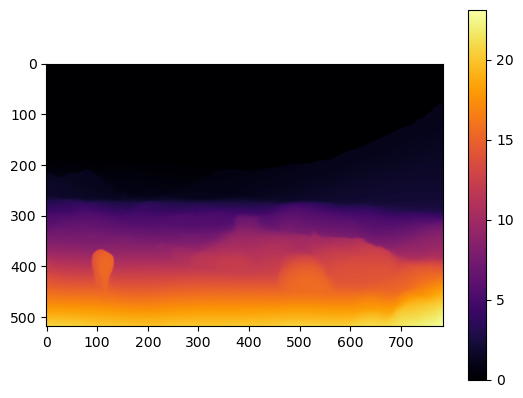

In [20]:
image = Image.open('Saved Images/dog.png')
depth_map=estimate_depth(image, depth_model)
plt.imshow(depth_map.squeeze().cpu().detach().numpy(), cmap='inferno')
plt.colorbar()
plt.show()

In [11]:
print(depth)
torch.save(depth, 'depth.pt')

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [20.7269, 20.5721, 20.5650,  ..., 22.7805, 22.8222, 22.9899],
         [20.6496, 20.5735, 20.6192,  ..., 22.7140, 22.9852, 23.1069],
         [18.0335, 20.4209, 20.7307,  ..., 22.5878, 23.0596, 21.1958]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)


In [ ]:
import matplotlib.pyplot as plt

plt.imshow(depth.squeeze().cpu().detach().numpy(), cmap='inferno')
plt.colorbar()
plt.savefig('Saved Images/depth.png', bbox_inches='tight', pad_inches=0)
plt.show()


#### Using the depth estimation to get different images

In [27]:
# We load the tensor of depth estimation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_tensor = torch.load('tensor.pt', map_location=device)
loaded_tensor = loaded_tensor.squeeze()

In [28]:
# Depth tensor
print(loaded_tensor.shape)
print(torch.max(loaded_tensor))

torch.Size([518, 784])
tensor(23.1069, grad_fn=<MaxBackward1>)


In [29]:
# Transformed image
print(image.shape)

torch.Size([1, 3, 518, 784])


In [30]:
# Original image
imagenoT = Image.open('Saved Images/dog.png')
imagenoT = torch.tensor(np.array(imagenoT) / 255.0)
print(imagenoT.shape)

torch.Size([332, 500, 3])


In [31]:
def plot_images(original, transformed, depth):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plotting original image
    ax[0].imshow(original)
    ax[0].set_title('Original Image')
    ax[0].axis('off')  # Turn off axis
    
    # Plotting transformed image
    # Squeezing to remove the batch dimension and permuting to get the channel last
    ax[1].imshow(transformed.squeeze().permute(1, 2, 0))
    ax[1].set_title('Transformed Image')
    ax[1].axis('off')
    
    # Plotting depth map
    # Detach the depth tensor and convert to numpy for plotting
    ax[2].imshow(depth.detach().numpy(), cmap='gray')  # Using a gray colormap for the depth map
    ax[2].set_title('Depth Estimation')
    ax[2].axis('off')
    
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


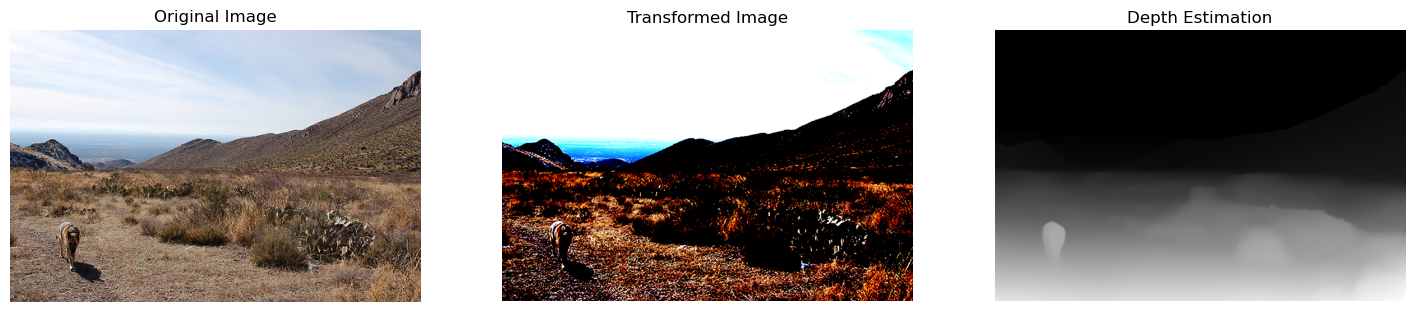

In [32]:
# Call the function with the example tensors
plot_images(imagenoT, image, loaded_tensor)

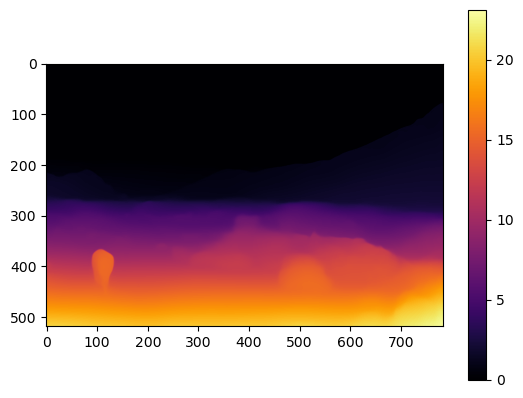

In [33]:
import matplotlib.pyplot as plt

plt.imshow(loaded_tensor.squeeze().cpu().detach().numpy(), cmap='inferno')
plt.colorbar()
plt.show()

Notice how you get a higher value for closer and lower value for further.

#### Attempt to apply the method

In [12]:
def plot(img):
    if torch.is_tensor(img):
        img = img.squeeze().detach().numpy()
    plt.imshow(img)

def plott(tensor):
    tensor = tensor.permute(1, 2, 0)
    plt.imshow(tensor)
    plt.show()

In [5]:
# Original image
original= Image.open('Saved Images/dog.png')
orgininalTensor = torch.tensor(np.array(original) / 255.0)
print(original.size)

(500, 332)


In [14]:
# We load the tensor of depth estimation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
depth = torch.load('tensor.pt', map_location=device)
#depth = loaded_tensor.squeeze()
print(depth.shape)

torch.Size([1, 518, 784])


In [7]:
import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor, to_pil_image

def filter_img_dist(original_img, depth, lower_quantile=0.25, upper_quantile=0.75):
    # Calculate threshold based on the depth quantiles
    lower_threshold = depth.quantile(lower_quantile)
    upper_threshold = depth.quantile(upper_quantile)
    
    # Create a mask where depth values are within the specified quartile range
    mask = (depth >= lower_threshold) & (depth <= upper_threshold)
    
    # Reshape the mask to match the batch dimension (N, H, W)
    mask = mask.squeeze(0).float()  # Remove the batch dimension (e.g., 1, 518, 784)

    # original_img.size gives (width, height), and we need (height, width) for the resize target size
    target_height, target_width = original_img.size[1], original_img.size[0]
    
    # Resize the mask to match the size of the original image using 'nearest' interpolation
    mask_resized = F.interpolate(mask.unsqueeze(0).unsqueeze(0), 
                                 size=(target_height, target_width),
                                 mode='nearest').squeeze(0).squeeze(0)  # Remove extra dimensions

    # Convert original image to tensor and ensure it's in uint8
    original_img_tensor = to_tensor(original_img)
    if original_img_tensor.max().item() <= 1.0:
        original_img_tensor = (original_img_tensor * 255).byte()  # Scale to 0-255 and convert to uint8

    # Prepare white image tensor, ensuring it matches the device and dtype of original image tensor
    white_img_tensor = torch.ones_like(original_img_tensor) * 255  # Use 255 to represent white in uint8

    # Ensure mask is expanded to all RGB channels correctly
    mask_rgb = mask_resized.unsqueeze(0).repeat(3, 1, 1)  # Repeat the mask for 3 channels (3, H, W)

    # Combine original image and white image based on the resized mask
    combined_img_tensor = torch.where(mask_rgb.bool(), original_img_tensor, white_img_tensor)

    # Convert the final tensor to a PIL image
    final_image = to_pil_image(combined_img_tensor)
    return final_image

In [8]:
print(depth.shape)
print(original.size)

torch.Size([1, 518, 784])
(500, 332)


In [18]:
img=filter_img_dist(original, depth, 0.7, 0.9)

In [16]:
torch.max(depth).item()

23.10689353942871

In [10]:
# Prediction using CLIP out of the box
prediction1, probs1, entropy1 = clip_model.predict(img)
print(prediction1)
print(entropy1)
print(probs1)

41
5.727802753448486
tensor([0.0009, 0.0013, 0.0021, 0.0180, 0.0144, 0.0147, 0.0007, 0.0049, 0.0054,
        0.0189, 0.0027, 0.0099, 0.0037, 0.0012, 0.0012, 0.0137, 0.0035, 0.0162,
        0.0041, 0.0289, 0.0022, 0.0029, 0.0033, 0.0014, 0.0010, 0.0075, 0.0054,
        0.0638, 0.0011, 0.0339, 0.0009, 0.0086, 0.0162, 0.0049, 0.0085, 0.0083,
        0.0037, 0.0144, 0.0047, 0.0022, 0.0007, 0.0821, 0.0094, 0.0129, 0.0363,
        0.0012, 0.0094, 0.0019, 0.0057, 0.0134, 0.0059, 0.0057, 0.0107, 0.0002,
        0.0002, 0.0097, 0.0047, 0.0005, 0.0150, 0.0307, 0.0480, 0.0037, 0.0099,
        0.0108, 0.0047, 0.0084, 0.0017, 0.0103, 0.0100, 0.0032, 0.0005, 0.0038,
        0.0238, 0.0013, 0.0462, 0.0028, 0.0008, 0.0045, 0.0143, 0.0007, 0.0018,
        0.0001, 0.0004, 0.0002, 0.0089, 0.0460, 0.0059, 0.0047, 0.0024, 0.0077,
        0.0029, 0.0047, 0.0002, 0.0110, 0.0012, 0.0095, 0.0339, 0.0114, 0.0095,
        0.0111])


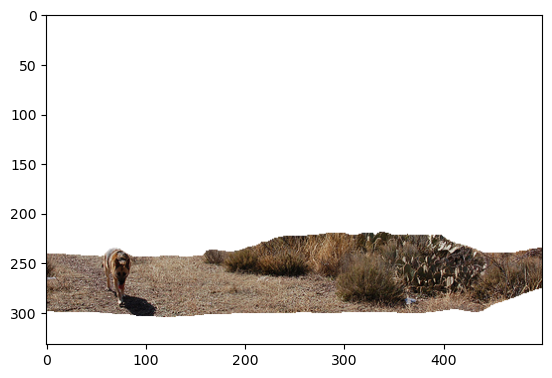

In [20]:
plot(img)

In [17]:
type(img)

PIL.Image.Image

# References

1. Radford, A., Kim, J. W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., ... & Sutskever, I. (2021). [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020). *arXiv preprint arXiv:2103.00020*.

2. Wang, H., Ge, S., Xing, E. P., & Lipton, Z. C. (2021). [MEMO: Test Time Robustness via Adaptation and Augmentation](https://arxiv.org/pdf/2110.09506). *arXiv preprint arXiv:2110.09506*.

3. Shu, Y., Wang, W., Bai, S., & Wang, H. (2022). [Test-Time Prompt Tuning for Zero-Shot Generalization in Vision-Language Models](https://arxiv.org/pdf/2209.07511). *arXiv preprint arXiv:2209.07511*.

4. Yang, L., Kang, B., Li, X., Zhao, F., Zhang, J., Xiao, B., & Song, L. (2024). [Depth Anything: Unleashing the Power of Large-Scale Unlabeled Data](https://arxiv.org/abs/2401.10891). *arXiv preprint arXiv:2401.10891*.
   
   [GitHub Repository](https://github.com/LiheYoung/Depth-Anything)

5. Zhou, K., Yang, J., Loy, C. C., & Liu, Z. (2021). [Learning to Prompt for Vision-Language Models](https://arxiv.org/abs/2109.01134). *arXiv preprint arXiv:2109.01134*.